### MPA_kNN

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

### Saving into Log

In [2]:
import logging

# Setup basic configuration for logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[
                        logging.FileHandler("kNN_optimization_MIT_new.log"),  # Log to this file
                        logging.StreamHandler()  # Log to standard output
                    ])

### Determining necessary parameters

In [3]:
import numpy as np

# Example usage with the correct bounds for SVM:
search_agents_no = 30  # number of search agents
dim = 2  # number of dimensions / hyperparameters
Max_iter = 20  # Maximum number of iterations

# Lower bounds for KNN parameters
n_neighbors_lb = 2
p_lb = 1

# Upper bounds for KNN parameters
n_neighbors_ub = 60
p_ub = 40

# Create arrays of lower bounds (lb) and upper bounds (ub) for KNN
lb = np.array([n_neighbors_lb, p_lb])
ub = np.array([n_neighbors_ub, p_ub])


### Loading Training Dataset

In [4]:
import cudf
import pandas as pd
from cuml.neighbors import KNeighborsClassifier
from cuml.metrics import accuracy_score
from cuml.model_selection import train_test_split
from cuml.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import RandomOverSampler

# Load and prepare data
train_data = cudf.read_csv('/home/jupyter-yangiev/MPA_int_ML/mitbih_train_new.csv')

columns = train_data.columns.tolist()
features = [col for col in columns if col != '187']
labels = '187'

# Split features and labels
X = train_data[features].astype('float32')  # Convert feature data to float32
y = train_data[labels].astype('int32')      # Assuming your target data is for classification and should be integers

# Convert to Pandas DataFrame for resampling
X_pd = X.to_pandas()
y_pd = y.to_pandas()

# Apply Resampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_pd, y_pd)

# Convert resampled data back to cuDF DataFrames for further processing with cuML
X_resampled = cudf.DataFrame.from_pandas(X_resampled)
y_resampled = cudf.Series(y_resampled)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

2024-04-16 03:59:06,468 - INFO - init


### Levy, Initialization, Fitness and Confusion Matrix Plot Functions

In [5]:
import math

# Levy function
def levy(search_agents_no, dim, beta=3/2):
    sigma = (math.gamma(1 + beta) * np.sin(np.pi * beta / 2)) / \
            (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2)) ** (1 / beta)
    u = np.random.randn(search_agents_no, dim) * sigma
    v = np.random.randn(search_agents_no, dim)
    step = u / (np.abs(v) ** (1 / beta))
    L = 0.05 * step  # Scale factor can be adjusted as needed
    return L

# Prey initialization function 
def initialization(search_agents_no, dim, ub, lb):
    if np.isscalar(lb) and np.isscalar(ub):
        # If the boundaries are both single numbers, apply them to all dimensions
        positions = np.random.rand(search_agents_no, dim) * (ub - lb) + lb
    else:
        # If the boundaries are arrays with different values for each dimension
        positions = np.zeros((search_agents_no, dim))
        for i in range(dim):
            ub_i = ub[i]
            lb_i = lb[i]
            positions[:, i] = np.random.rand(search_agents_no) * (ub_i - lb_i) + lb_i
    return positions

# Objective fitness function 
def kNN_accuracy_fitness(X_params, X_train, y_train, X_val, y_val):
    
    print("X_params shape:", X_params.shape)
    n_neighbors, p = int(round(X_params[0][0])), int(round(X_params[0][1]))
    print("n_neighbors:", n_neighbors, "p:", p)
    
    # Initialize the kNN model
    model = KNeighborsClassifier(n_neighbors=n_neighbors, p=p, weights='uniform')

    # Fit model on the training data
    model.fit(X_train, y_train)
    
    # Predict on validation set
    preds = model.predict(X_val)
    
    # Ensure predictions are integers
    preds = preds.astype('int32')
    
    # Compute overall accuracy
    overall_fitness = accuracy_score(y_val, preds)
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_val, preds)
    
    # Calculate per-class accuracy
    if hasattr(conf_matrix, 'get'):
        conf_matrix = conf_matrix.get()  # Convert from CuPy to NumPy if necessary
    true_positives = np.diag(conf_matrix)
    total_predictions = np.sum(conf_matrix, axis=1)
    
    # Handle cases where there are no predictions for a class
    with np.errstate(divide='ignore', invalid='ignore'):
        per_class_accuracy = true_positives / total_predictions
        per_class_accuracy = np.nan_to_num(per_class_accuracy)  # Convert NaNs to zero if any class was not predicted at all
    
    # Calculate mean of per-class accuracies
    fitness = np.mean(per_class_accuracy)  # Use mean to get average per-class accuracy

    # Return mean per-class accuracies along with the confusion matrix
    return fitness, conf_matrix


# Confusion Matrix Plot function
def plot_confusion_matrix(conf_matrix, individual_index):
    if hasattr(conf_matrix, 'get'):
        conf_matrix_np = conf_matrix.get()  # Convert CuPy array to NumPy array
    else:
        conf_matrix_np = np.array(conf_matrix)  # Ensure it is a NumPy array

    # Calculate the percentage of each element relative to the row sum
    row_sums = conf_matrix_np.sum(axis=1)[:, np.newaxis]  # Reshape for broadcasting
    conf_matrix_percent = 100 * conf_matrix_np / row_sums
    conf_matrix_percent = np.nan_to_num(conf_matrix_percent)  # Replace nan with 0, can occur if row sum is 0

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues", cbar=True, ax=ax)

    # Adjust the subplot params for a nicer fit
    plt.subplots_adjust(left=0.2, right=0.8, top=0.95, bottom=0.15)

    plt.title(f'Confusion Matrix for Individual {individual_index + 1}')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')

    # Set the custom tick labels for each axis
    ax.set_xticklabels(['N', 'S', 'V', 'F', 'Q'], rotation=0)
    ax.set_yticklabels(['N', 'S', 'V', 'F', 'Q'])

    plt.show()


def get_model_from_params(params):
    n_neighbors, p = round(params[0]), round(params[1])
    model = KNeighborsClassifier(n_neighbors=int(n_neighbors), p=int(p), weights='uniform')
    return model




### Define MPA function

In [6]:
import pickle

def MPA(search_agents_no, Max_iter, lb, ub, dim, X_train, y_train, X_val, y_val, kNN_accuracy_fitness, fitness_threshold=0.95):
   
    Top_predator_pos = np.zeros(dim)
    Top_predator_fit = -np.inf  # Start with the lowest possible value
    best_model = None  # Variable to store the best model
    
    stepsize = np.zeros((search_agents_no, dim))
    fitness = np.full(search_agents_no, -np.inf)
     
    Prey = initialization(search_agents_no, dim, ub, lb)
    model_path = 'best_model_mpa_kNN_mit.pkl'  # Define the path where the model will be saved
    Xmin = np.tile(lb, (search_agents_no, 1))
    Xmax = np.tile(ub, (search_agents_no, 1))

    best_fitness_values = []  # Keep track of the best fitness value at each iteration
    average_fitness_values = []  # Keep track of the average fitness value
    
    Iter = 0
    FADs = 0.2
    P = 0.5

    for Iter in range(Max_iter):
        # Detecting Top predator
        for i in range(search_agents_no):
            Flag4ub = Prey[i, :] > ub
            Flag4lb = Prey[i, :] < lb
            Prey[i, :] = Prey[i, :] * (~(Flag4ub | Flag4lb)) + ub * Flag4ub + lb * Flag4lb
            logging.info(f"Calculating fitness for individual {i+1}/{search_agents_no}")
            fitness[i], conf_matrix = kNN_accuracy_fitness(Prey[[i], :], X_train, y_train, X_val, y_val)
           
            logging.info(f"Fitness for individual {i+1}: {fitness[i]}")
            # Plot the confusion matrix for the current individual
            plot_confusion_matrix(conf_matrix, i)
            
            if fitness[i] > Top_predator_fit:
                Top_predator_fit = fitness[i]
                Top_predator_pos = Prey[i, :].copy()
                best_model = get_model_from_params(Top_predator_pos)  # Assuming you have a function to create a model from params
                
        # Marine memory saving
        if Iter == 0:
            fit_old = fitness.copy()
            Prey_old = Prey.copy()
        
        # For maximization: Check if the current fitness is greater than the old fitness
        Inx = fitness > fit_old
        Indx = np.tile(Inx[:, None], (1, dim))
        
        # Update positions: Use the newer positions if the current fitness is better; otherwise, revert to old positions
        Prey = Indx * Prey + (~Indx) * Prey_old
        
        # Update fitness: Keep the higher current fitness values; otherwise, revert to old fitness values
        fitness = np.where(Inx, fitness, fit_old)
        
        fit_old = fitness.copy()  # Prepare for the next iteration
        Prey_old = Prey.copy()

        # --------------------////------------------
        Elite = np.tile(Top_predator_pos, (search_agents_no, 1))  # Construct Elite Matrix
        CF = (1 - Iter / Max_iter) ** (2 * Iter / Max_iter)

        RL = 0.05 * levy(search_agents_no, dim, 1.5)    # Levy random number vector
        RB = np.random.randn(search_agents_no, dim)     # Brownian random number vector

        for i in range(search_agents_no):
            for j in range(dim):
                R = np.random.rand()
                # Phase 1
                if Iter < Max_iter / 3:
                    stepsize[i, j] = RB[i, j] * (Elite[i, j] - RB[i, j] * Prey[i, j])
                    Prey[i, j] = Prey[i, j] + P * R * stepsize[i, j]
                # Phase 2
                elif Max_iter / 3 < Iter < 2 * Max_iter / 3:
                    if i > search_agents_no / 2:
                        stepsize[i, j] = RB[i, j] * (RB[i, j] * Elite[i, j] - Prey[i, j])
                        Prey[i, j] = Elite[i, j] + P * CF * stepsize[i, j]
                    else:
                        stepsize[i, j] = RL[i, j] * (Elite[i, j] - RL[i, j] * Prey[i, j])
                        Prey[i, j] = Prey[i, j] + P * R * stepsize[i, j]
                # Phase 3
                else:
                    stepsize[i, j] = RL[i, j] * (RL[i, j] * Elite[i, j] - Prey[i, j])
                    Prey[i, j] = Elite[i, j] + P * CF * stepsize[i, j]
                # ------------------ Detecting top predator ------------------  
        for i in range(search_agents_no):
            # Enforce boundary conditions
            Flag4ub = Prey[i, :] > ub
            Flag4lb = Prey[i, :] < lb
            Prey[i, :] = (Prey[i, :] * (~(Flag4ub | Flag4lb))) + ub * Flag4ub + lb * Flag4lb
            logging.info(f"Calculating fitness for individual after 3 Phases {i+1}/{search_agents_no}")
            # Evaluate fitness
            fitness[i], conf_matrix = kNN_accuracy_fitness(Prey[[i], :], X_train, y_train, X_val, y_val)
           
            logging.info(f"Fitness for individual {i+1}: {fitness[i]}")
            # Plot the confusion matrix for the current individual
            plot_confusion_matrix(conf_matrix, i)
            
            # Update top predator if current solution is better (for maximization)
            if fitness[i] > Top_predator_fit:
                Top_predator_fit = fitness[i]
                Top_predator_pos = Prey[i, :].copy()
                best_model = get_model_from_params(Top_predator_pos)  # Assuming you have a function to create a model from params
                
        # Marine memory saving  --------///-----------
        if Iter == 0:
            fit_old = fitness.copy()
            Prey_old = Prey.copy()
        
        Inx = fitness > fit_old  # For maximization: keep if current fitness is better
        Indx = np.tile(Inx[:, None], (1, dim))
        Prey = Indx * Prey + (~Indx) * Prey_old  # Update positions based on better fitness
        fitness = np.where(Inx, fitness, fit_old)  # Update fitness values accordingly
        
        fit_old = fitness.copy()  # Update old fitness for the next iteration
        Prey_old = Prey.copy()  # Update old positions for the next iteration
        
        
        # Eddy formation and FADs’ effect
        if np.random.rand() < FADs:
            U = np.random.rand(search_agents_no, dim) < FADs
            Prey = Prey + CF * ((Xmin + np.random.rand(search_agents_no, dim) * (Xmax - Xmin)) * U)
        else:
            r = np.random.rand()
            Rs = Prey.shape[0]
            stepsize = (FADs * (1 - r) + r) * (Prey[np.random.permutation(Rs), :] - Prey[np.random.permutation(Rs), :])
            Prey = Prey + stepsize

        current_best_fitness = Top_predator_fit
        best_fitness_values.append(current_best_fitness)
        
        # Calculate average fitness of the population
        current_avg_fitness = np.mean(fitness)
        average_fitness_values.append(current_avg_fitness)
        
        # Log the metrics
        logging.info(f"Iteration: {Iter+1}/{Max_iter}, Best Fitness: {current_best_fitness}, Average Fitness: {current_avg_fitness}")
        
        if Top_predator_fit >= fitness_threshold:
            logging.info(f"Fitness threshold reached: {Top_predator_fit} at iteration {Iter+1}. Terminating...")
            with open(model_path, 'wb') as f:
                pickle.dump(best_model, f)  # Save the best model
            logging.info(f"Model saved to {model_path} with fitness {Top_predator_fit} at iteration {Iter+1}")
            break  # Exit the loop if fitness threshold is reached
        
        # Update iteration counter and convergence curve
        Iter += 1

    return Top_predator_pos, Top_predator_fit


### Call MPA

2024-04-16 03:59:09,649 - INFO - Calculating fitness for individual 1/30


X_params shape: (1, 2)
n_neighbors: 14 p: 9


2024-04-16 03:59:14,238 - INFO - Fitness for individual 1: 0.9869178914251417


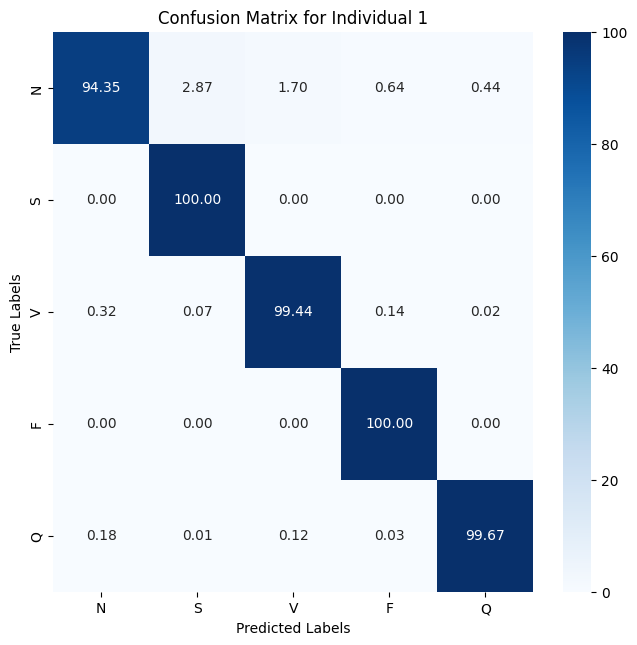

2024-04-16 03:59:14,650 - INFO - Calculating fitness for individual 2/30


X_params shape: (1, 2)
n_neighbors: 32 p: 30


2024-04-16 03:59:18,912 - INFO - Fitness for individual 2: 0.9714855869479722


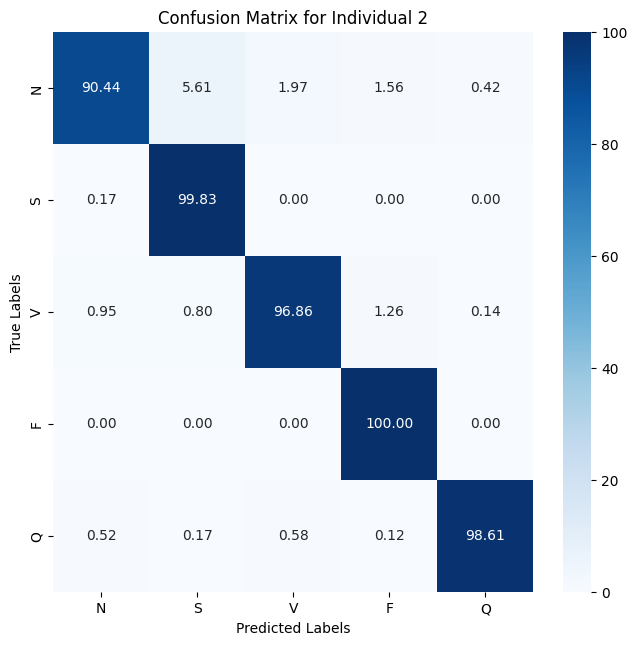

2024-04-16 03:59:19,303 - INFO - Calculating fitness for individual 3/30


X_params shape: (1, 2)
n_neighbors: 49 p: 13


2024-04-16 03:59:23,906 - INFO - Fitness for individual 3: 0.9583933485302822


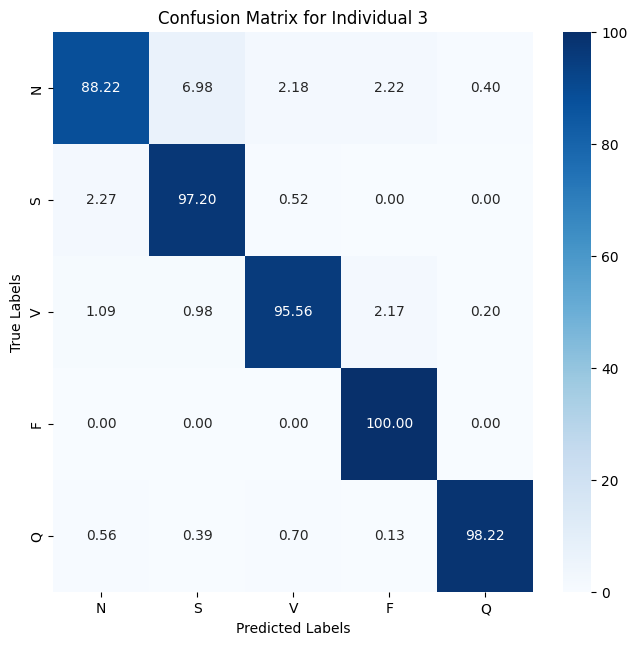

2024-04-16 03:59:24,352 - INFO - Calculating fitness for individual 4/30


X_params shape: (1, 2)
n_neighbors: 26 p: 9


2024-04-16 03:59:28,634 - INFO - Fitness for individual 4: 0.9753927915503073


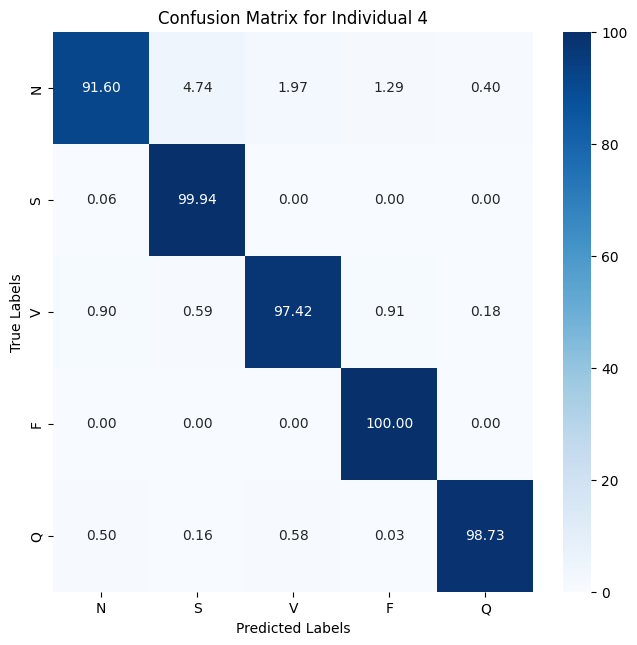

2024-04-16 03:59:29,023 - INFO - Calculating fitness for individual 5/30


X_params shape: (1, 2)
n_neighbors: 26 p: 30


2024-04-16 03:59:33,254 - INFO - Fitness for individual 5: 0.9753927915503073


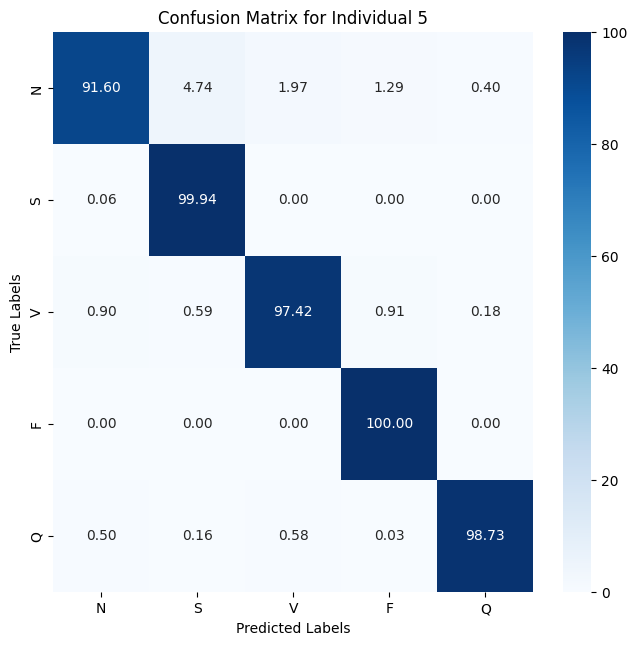

2024-04-16 03:59:33,642 - INFO - Calculating fitness for individual 6/30


X_params shape: (1, 2)
n_neighbors: 33 p: 4


2024-04-16 03:59:38,202 - INFO - Fitness for individual 6: 0.9703769274751224


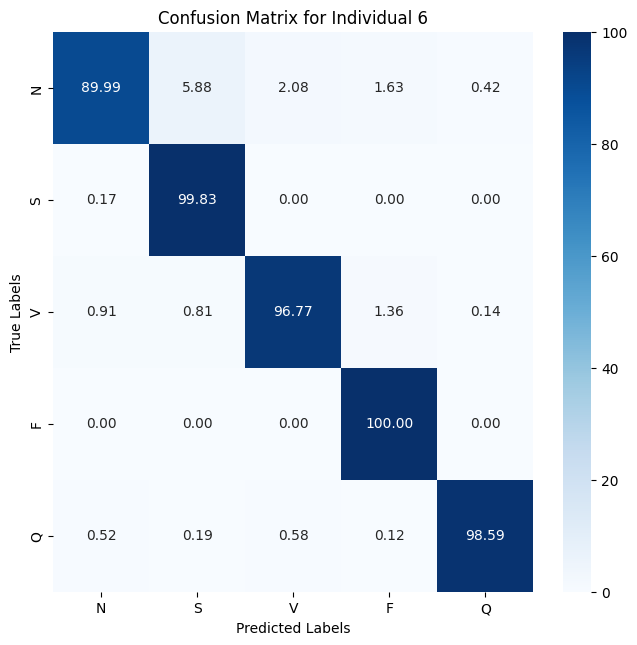

2024-04-16 03:59:38,591 - INFO - Calculating fitness for individual 7/30


X_params shape: (1, 2)
n_neighbors: 18 p: 36


2024-04-16 03:59:42,944 - INFO - Fitness for individual 7: 0.9821551511374326


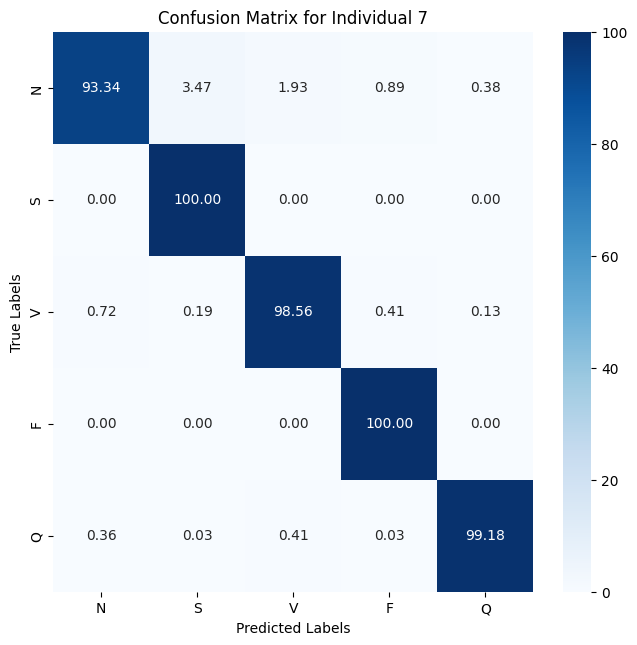

2024-04-16 03:59:43,330 - INFO - Calculating fitness for individual 8/30


X_params shape: (1, 2)
n_neighbors: 34 p: 13


2024-04-16 03:59:47,891 - INFO - Fitness for individual 8: 0.9701000586845883


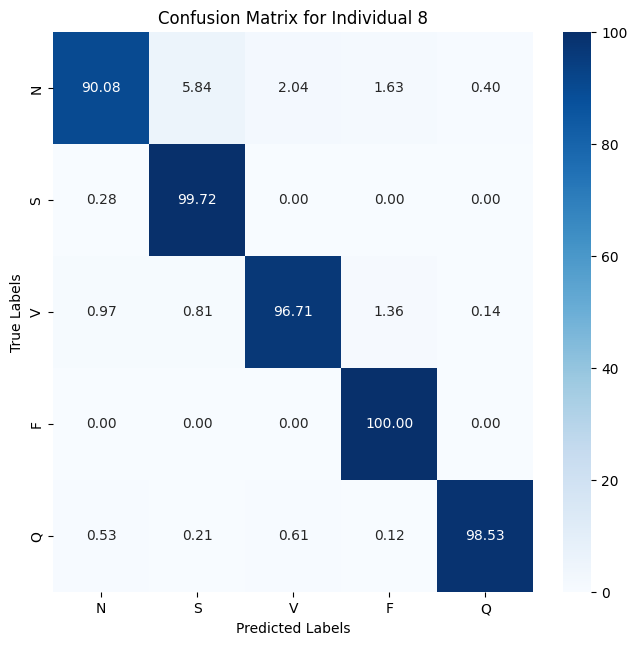

2024-04-16 03:59:48,279 - INFO - Calculating fitness for individual 9/30


X_params shape: (1, 2)
n_neighbors: 32 p: 8


2024-04-16 03:59:52,578 - INFO - Fitness for individual 9: 0.9714855869479722


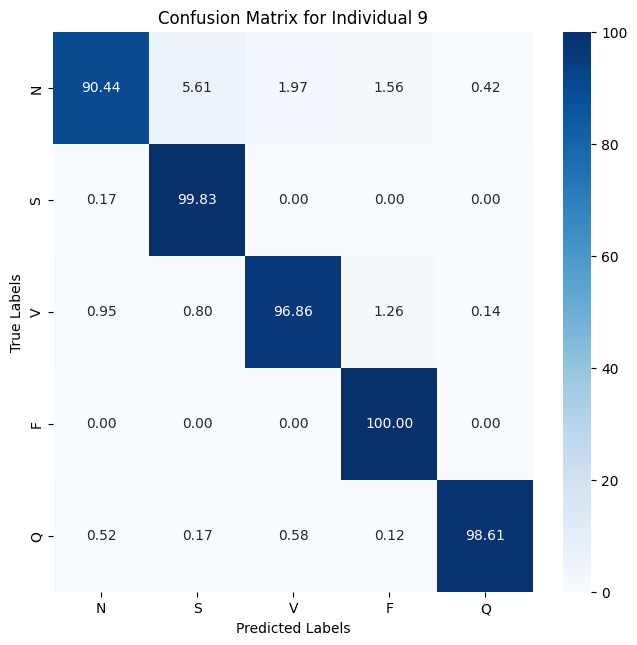

2024-04-16 03:59:52,964 - INFO - Calculating fitness for individual 10/30


X_params shape: (1, 2)
n_neighbors: 24 p: 1


2024-04-16 03:59:57,238 - INFO - Fitness for individual 10: 0.9767779910461336


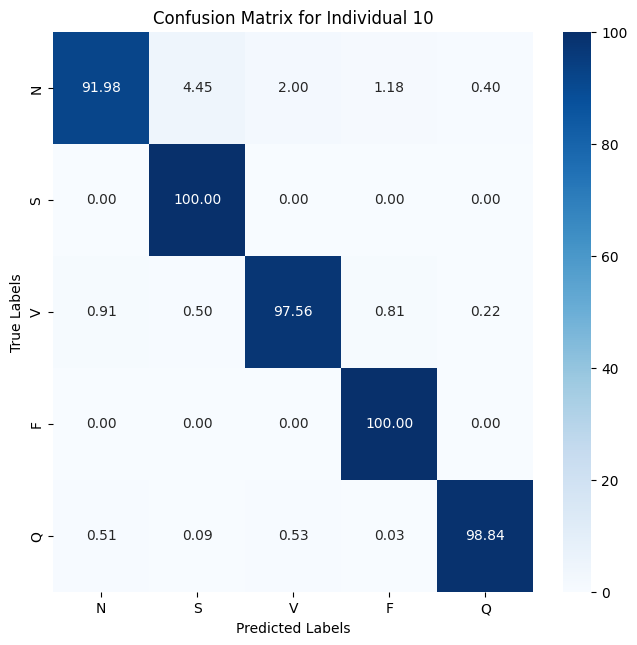

2024-04-16 03:59:57,626 - INFO - Calculating fitness for individual 11/30


X_params shape: (1, 2)
n_neighbors: 34 p: 32


2024-04-16 04:00:02,182 - INFO - Fitness for individual 11: 0.9701000586845883


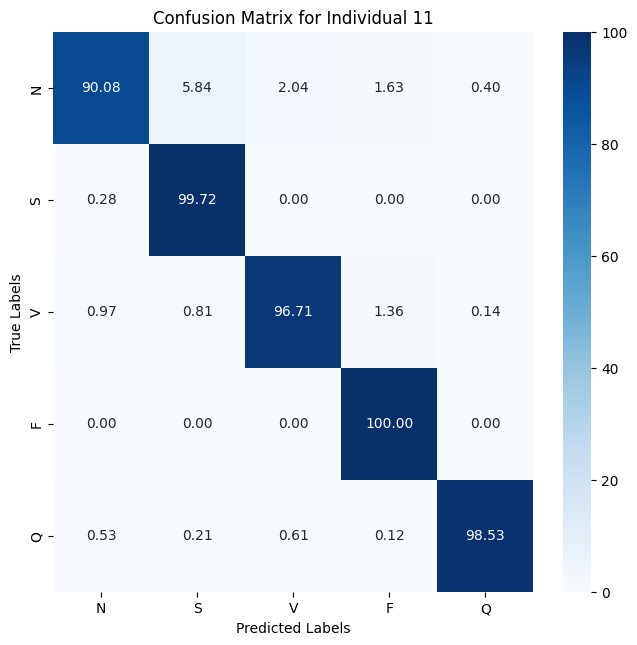

2024-04-16 04:00:02,792 - INFO - Calculating fitness for individual 12/30


X_params shape: (1, 2)
n_neighbors: 36 p: 27


2024-04-16 04:00:07,373 - INFO - Fitness for individual 12: 0.9689344911350808


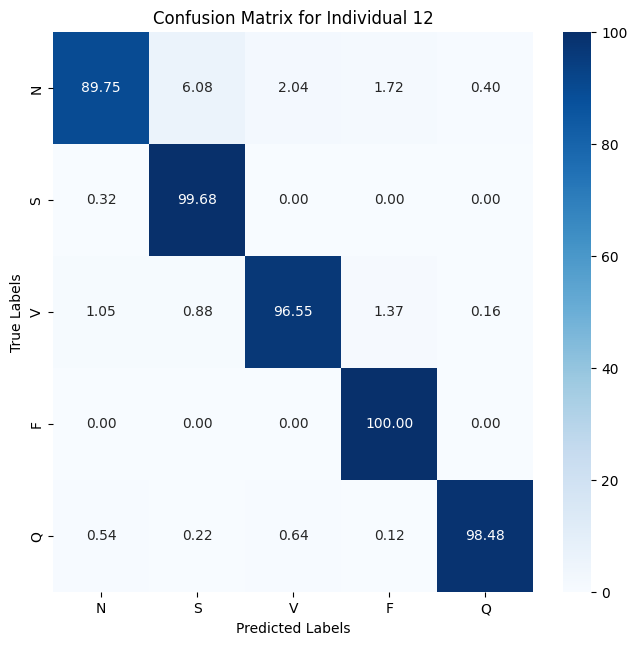

2024-04-16 04:00:07,758 - INFO - Calculating fitness for individual 13/30


X_params shape: (1, 2)
n_neighbors: 49 p: 40


2024-04-16 04:00:12,358 - INFO - Fitness for individual 13: 0.9583933485302822


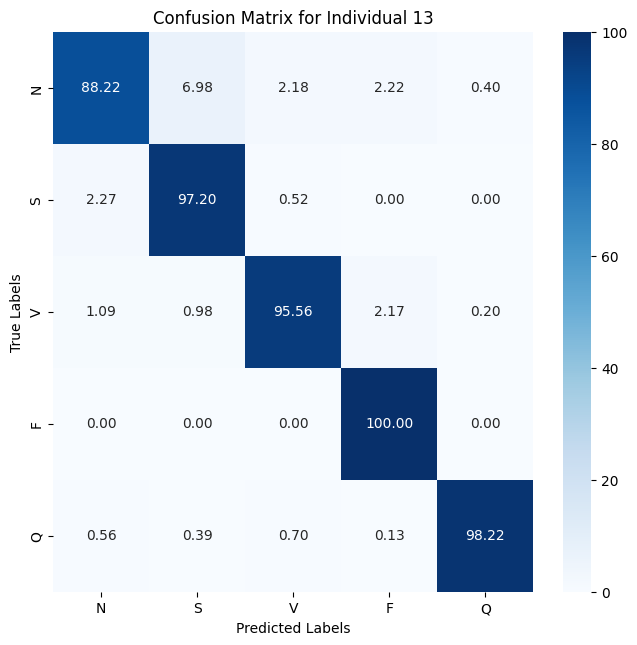

2024-04-16 04:00:12,747 - INFO - Calculating fitness for individual 14/30


X_params shape: (1, 2)
n_neighbors: 58 p: 7


2024-04-16 04:00:17,638 - INFO - Fitness for individual 14: 0.9533999993760258


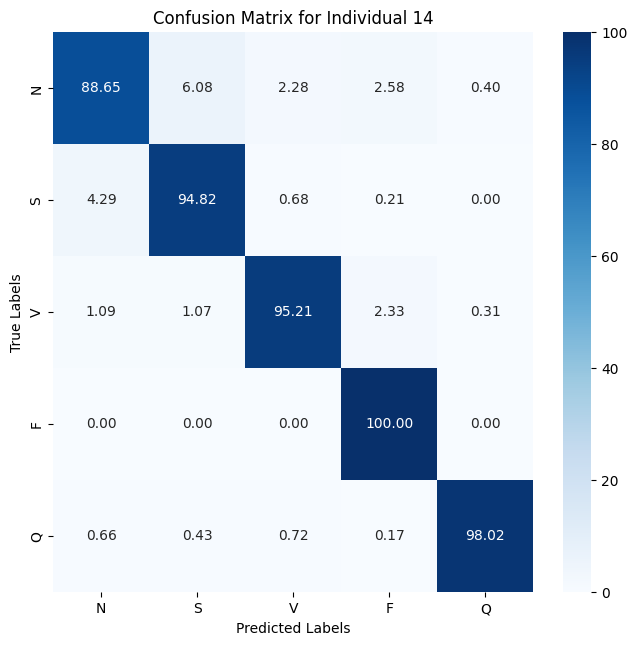

2024-04-16 04:00:18,025 - INFO - Calculating fitness for individual 15/30


X_params shape: (1, 2)
n_neighbors: 33 p: 14


2024-04-16 04:00:22,602 - INFO - Fitness for individual 15: 0.9703769274751224


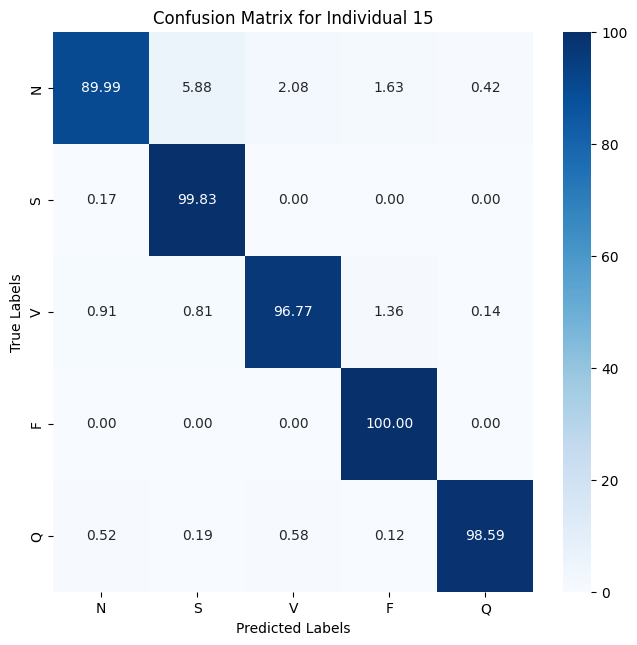

2024-04-16 04:00:22,986 - INFO - Calculating fitness for individual 16/30


X_params shape: (1, 2)
n_neighbors: 13 p: 18


2024-04-16 04:00:27,228 - INFO - Fitness for individual 16: 0.9872904136517594


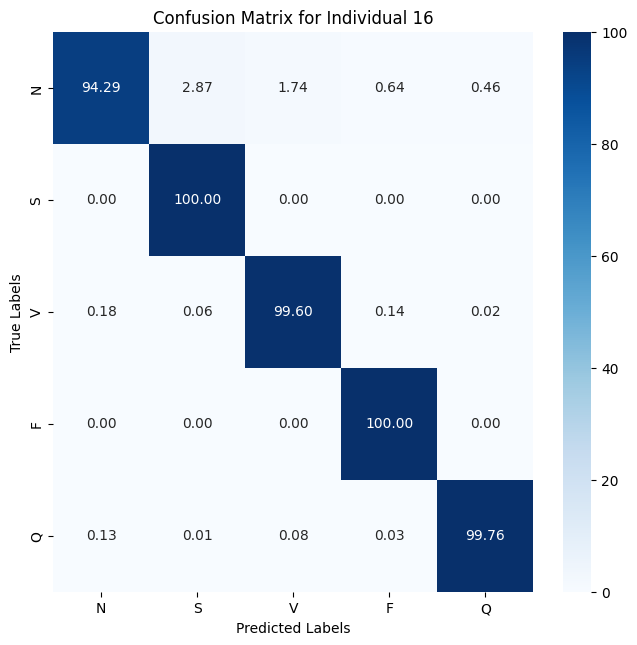

2024-04-16 04:00:27,603 - INFO - Calculating fitness for individual 17/30


X_params shape: (1, 2)
n_neighbors: 53 p: 33


2024-04-16 04:00:32,220 - INFO - Fitness for individual 17: 0.955927986749568


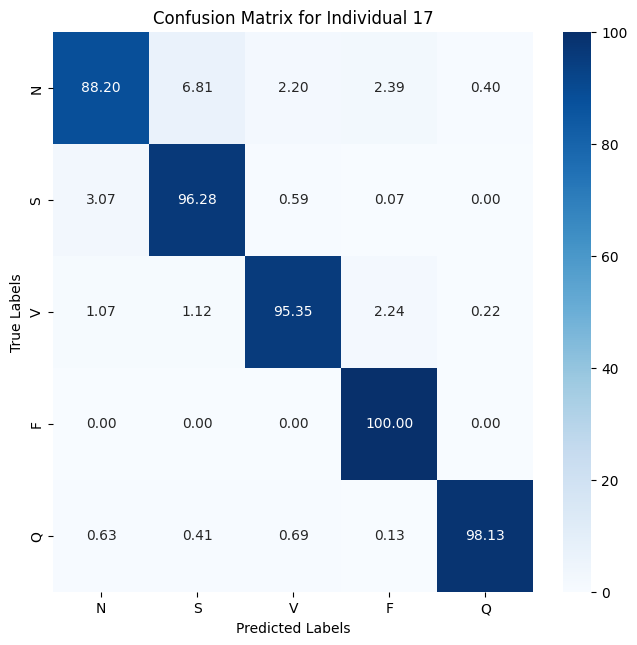

2024-04-16 04:00:32,596 - INFO - Calculating fitness for individual 18/30


X_params shape: (1, 2)
n_neighbors: 14 p: 15


2024-04-16 04:00:36,816 - INFO - Fitness for individual 18: 0.9869178914251417


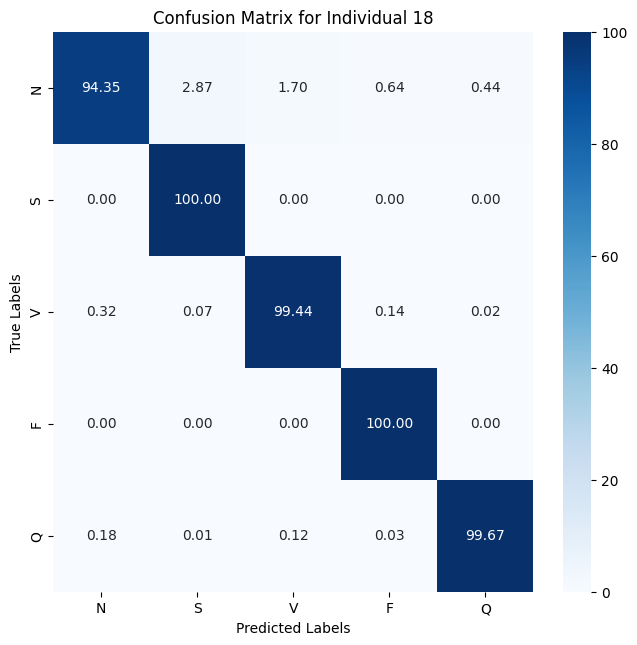

2024-04-16 04:00:37,188 - INFO - Calculating fitness for individual 19/30


X_params shape: (1, 2)
n_neighbors: 47 p: 27


2024-04-16 04:00:41,786 - INFO - Fitness for individual 19: 0.9601153907736606


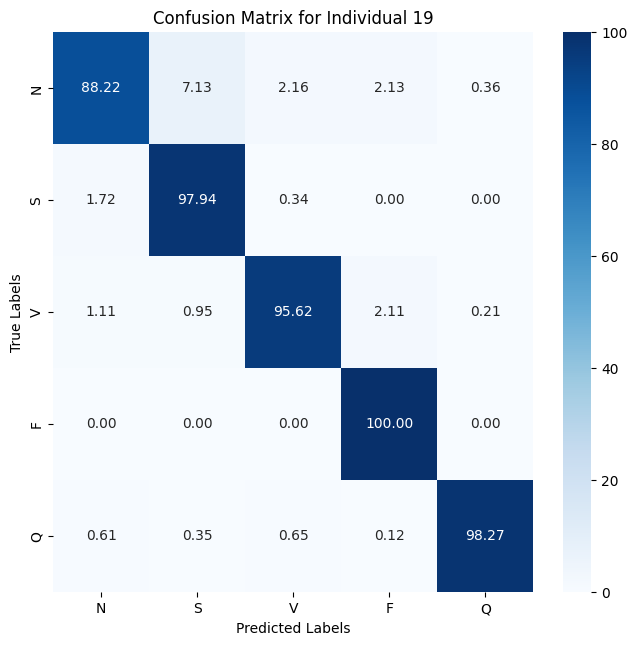

2024-04-16 04:00:42,162 - INFO - Calculating fitness for individual 20/30


X_params shape: (1, 2)
n_neighbors: 57 p: 12


2024-04-16 04:00:46,772 - INFO - Fitness for individual 20: 0.9539411434731171


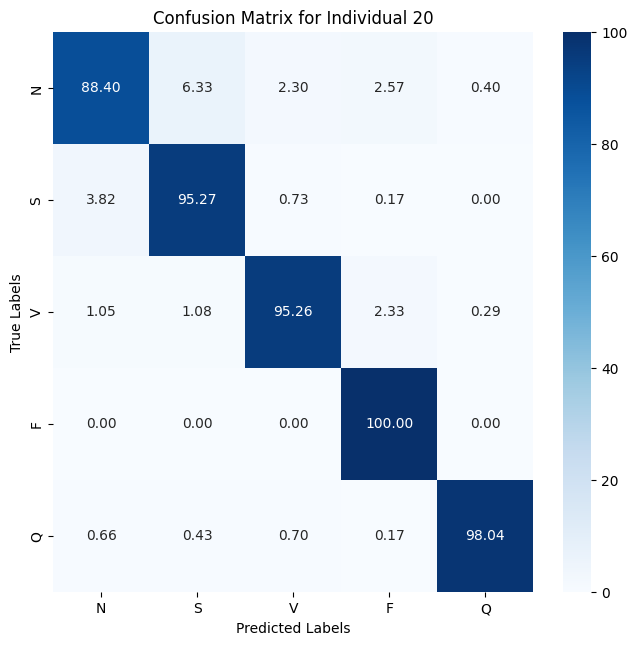

2024-04-16 04:00:47,146 - INFO - Calculating fitness for individual 21/30


X_params shape: (1, 2)
n_neighbors: 50 p: 35


2024-04-16 04:00:51,924 - INFO - Fitness for individual 21: 0.9581390536988401


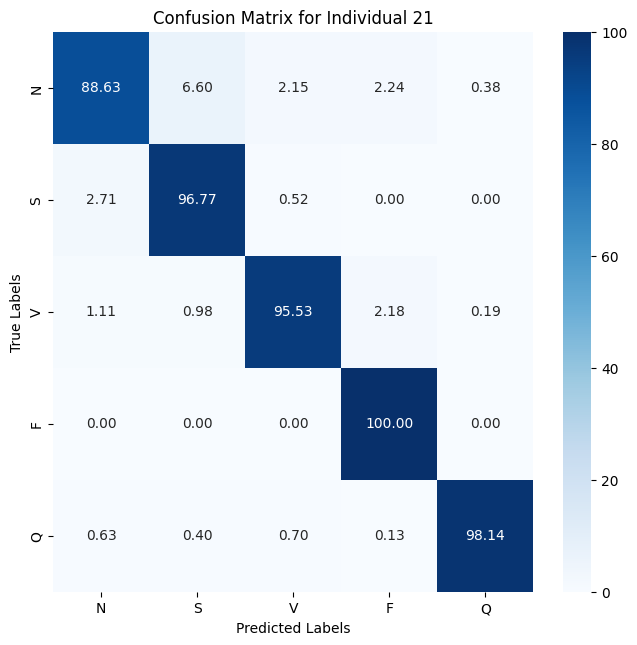

2024-04-16 04:00:52,300 - INFO - Calculating fitness for individual 22/30


X_params shape: (1, 2)
n_neighbors: 9 p: 11


2024-04-16 04:00:56,476 - INFO - Fitness for individual 22: 0.9908660643741092


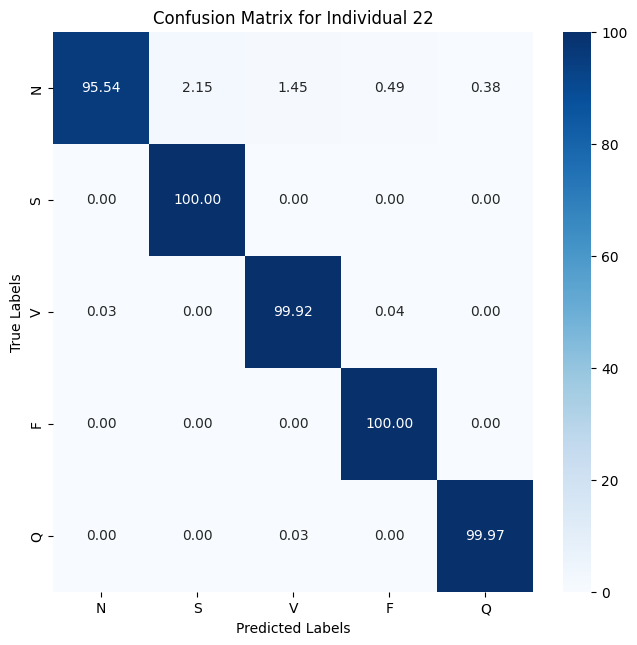

2024-04-16 04:00:56,846 - INFO - Calculating fitness for individual 23/30


X_params shape: (1, 2)
n_neighbors: 60 p: 32


2024-04-16 04:01:01,451 - INFO - Fitness for individual 23: 0.9525735727817051


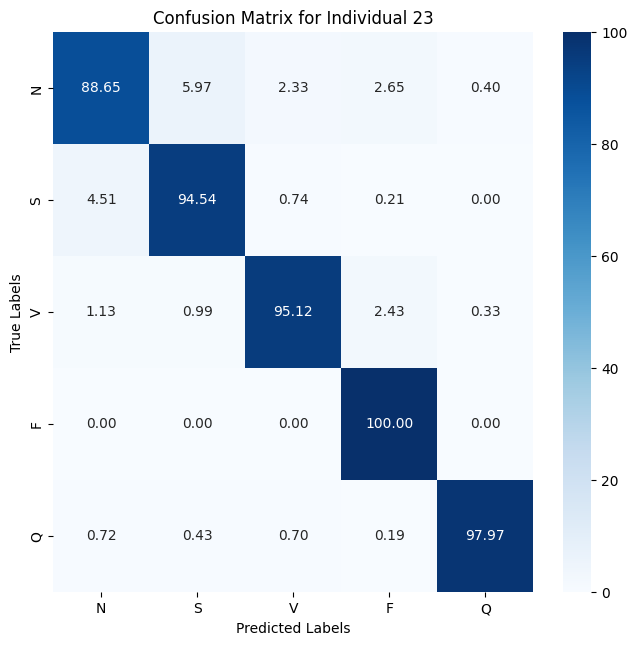

2024-04-16 04:01:01,828 - INFO - Calculating fitness for individual 24/30


X_params shape: (1, 2)
n_neighbors: 54 p: 10


2024-04-16 04:01:06,425 - INFO - Fitness for individual 24: 0.9557567127195628


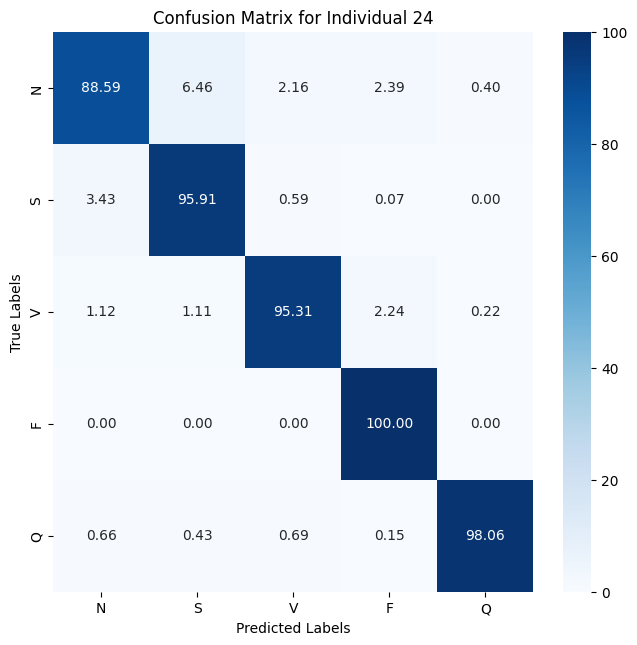

2024-04-16 04:01:06,799 - INFO - Calculating fitness for individual 25/30


X_params shape: (1, 2)
n_neighbors: 55 p: 7


2024-04-16 04:01:11,395 - INFO - Fitness for individual 25: 0.9551416928458943


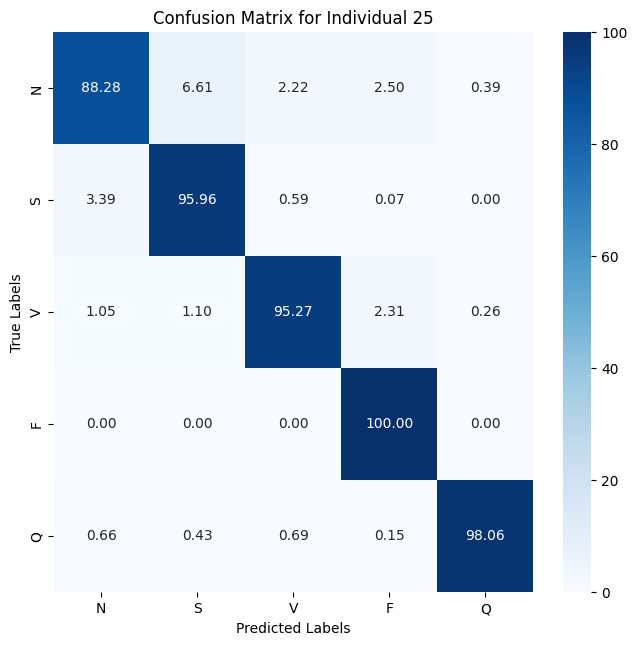

2024-04-16 04:01:12,017 - INFO - Calculating fitness for individual 26/30


X_params shape: (1, 2)
n_neighbors: 55 p: 28


2024-04-16 04:01:16,603 - INFO - Fitness for individual 26: 0.9551416928458943


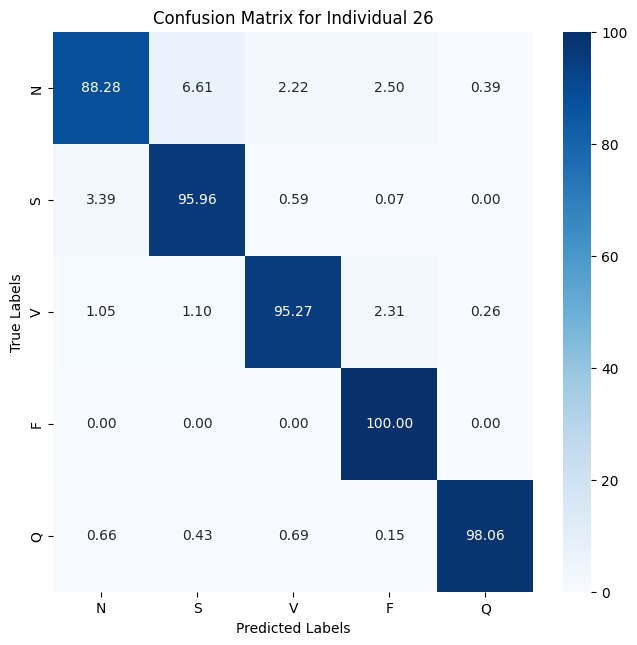

2024-04-16 04:01:16,977 - INFO - Calculating fitness for individual 27/30


X_params shape: (1, 2)
n_neighbors: 18 p: 21


2024-04-16 04:01:21,186 - INFO - Fitness for individual 27: 0.9821551511374326


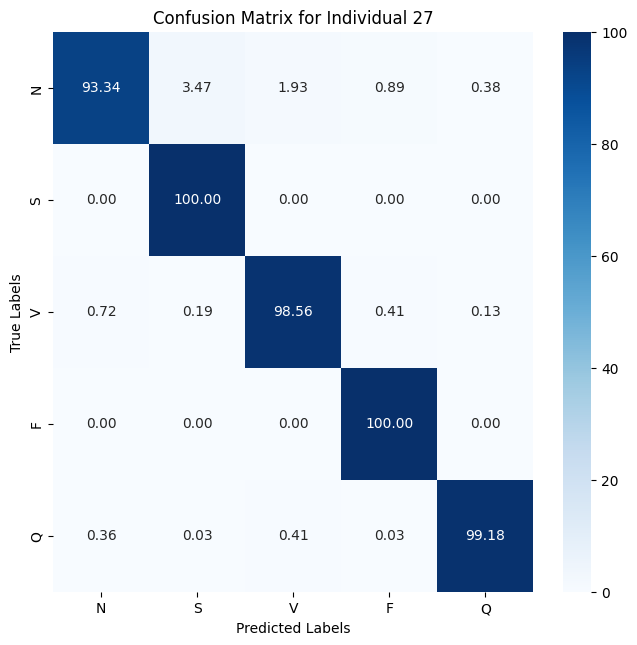

2024-04-16 04:01:21,558 - INFO - Calculating fitness for individual 28/30


X_params shape: (1, 2)
n_neighbors: 36 p: 12


2024-04-16 04:01:26,192 - INFO - Fitness for individual 28: 0.9689344911350808


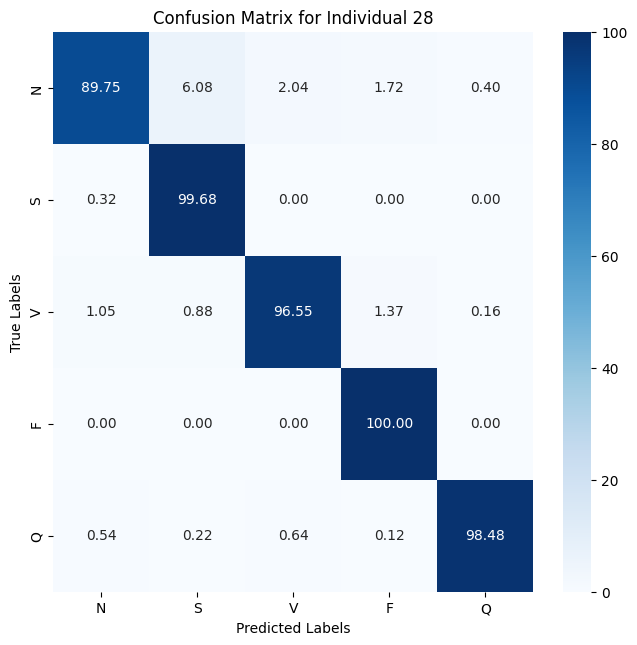

2024-04-16 04:01:26,565 - INFO - Calculating fitness for individual 29/30


X_params shape: (1, 2)
n_neighbors: 13 p: 37


2024-04-16 04:01:30,784 - INFO - Fitness for individual 29: 0.9872904136517594


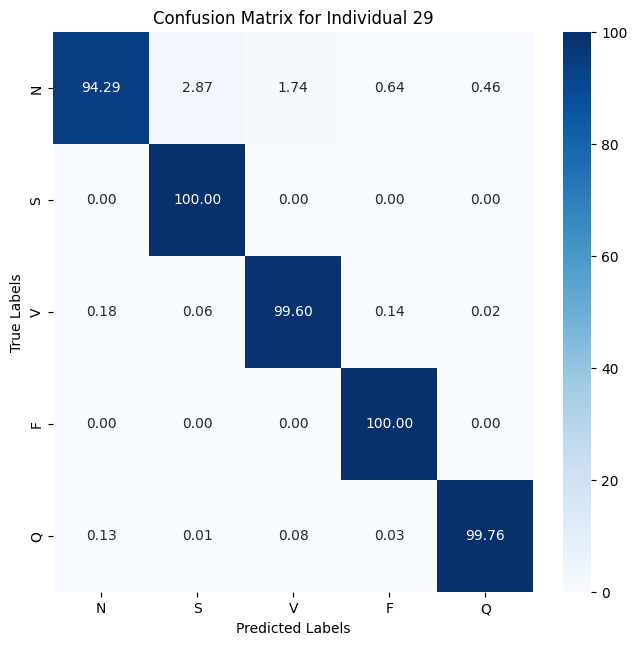

2024-04-16 04:01:31,155 - INFO - Calculating fitness for individual 30/30


X_params shape: (1, 2)
n_neighbors: 30 p: 19


2024-04-16 04:01:35,459 - INFO - Fitness for individual 30: 0.9727053224806955


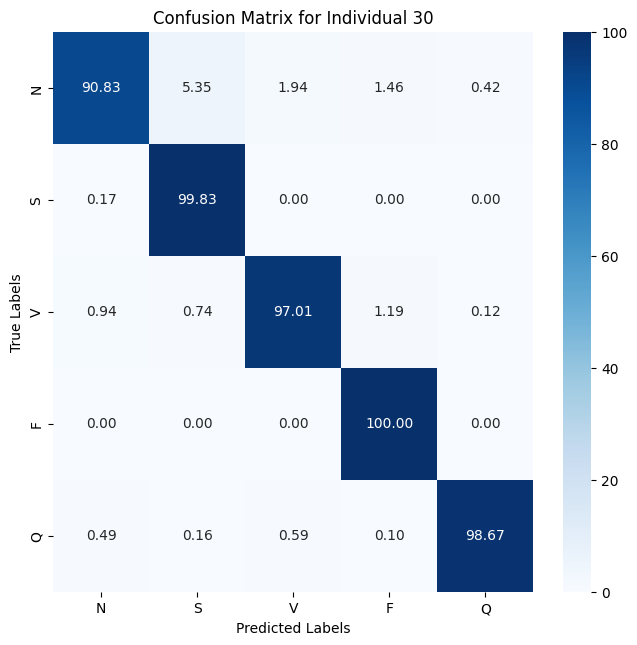

2024-04-16 04:01:35,833 - INFO - Calculating fitness for individual after 3 Phases 1/30


X_params shape: (1, 2)
n_neighbors: 11 p: 8


2024-04-16 04:01:40,028 - INFO - Fitness for individual 1: 0.9890441324278264


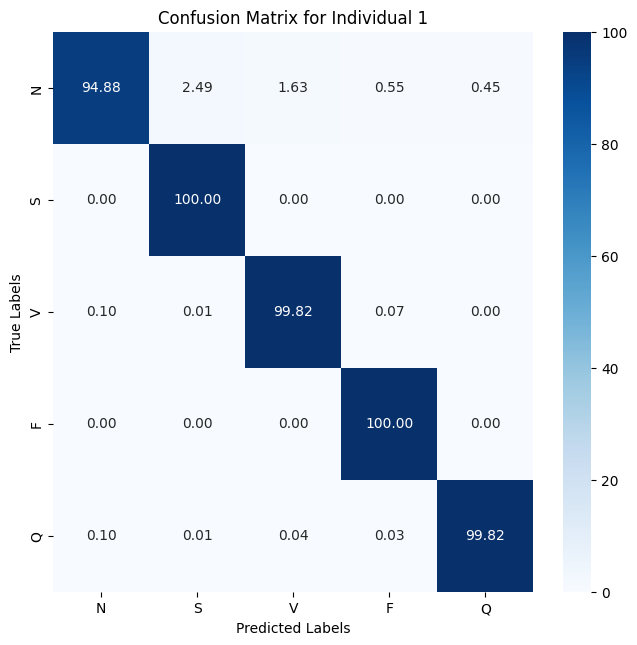

2024-04-16 04:01:40,397 - INFO - Calculating fitness for individual after 3 Phases 2/30


X_params shape: (1, 2)
n_neighbors: 30 p: 29


2024-04-16 04:01:44,700 - INFO - Fitness for individual 2: 0.9727053224806955


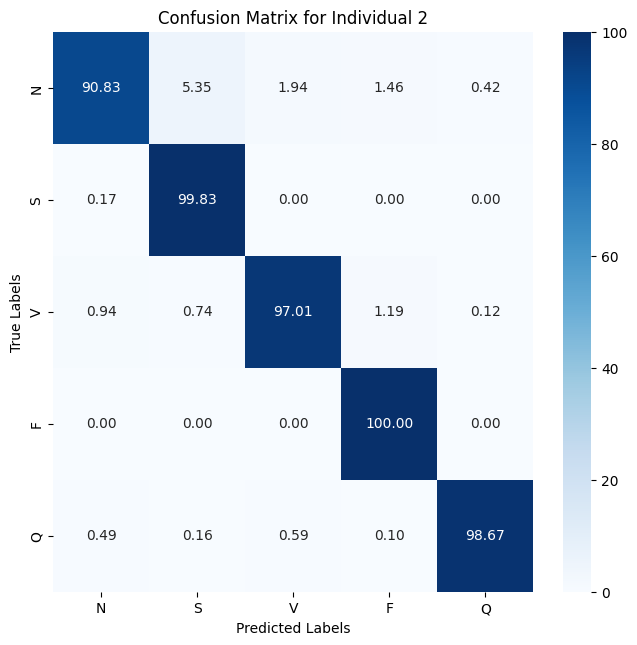

2024-04-16 04:01:45,072 - INFO - Calculating fitness for individual after 3 Phases 3/30


X_params shape: (1, 2)
n_neighbors: 32 p: 8


2024-04-16 04:01:49,319 - INFO - Fitness for individual 3: 0.9714855869479722


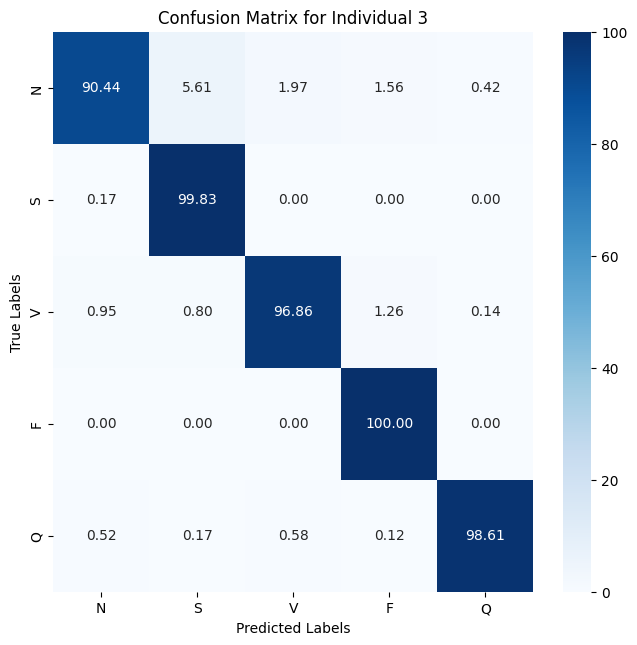

2024-04-16 04:01:49,691 - INFO - Calculating fitness for individual after 3 Phases 4/30


X_params shape: (1, 2)
n_neighbors: 7 p: 9


2024-04-16 04:01:53,853 - INFO - Fitness for individual 4: 0.9926720896848724


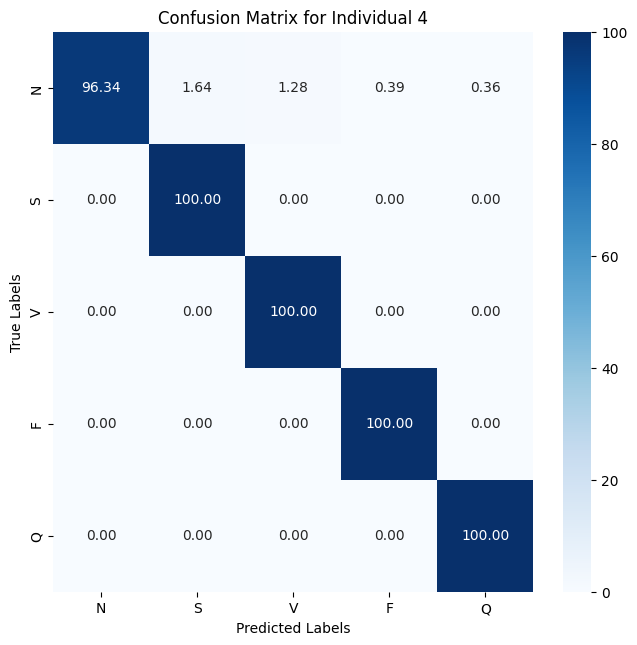

2024-04-16 04:01:54,219 - INFO - Calculating fitness for individual after 3 Phases 5/30


X_params shape: (1, 2)
n_neighbors: 23 p: 1


2024-04-16 04:01:58,392 - INFO - Fitness for individual 5: 0.9772884418674502


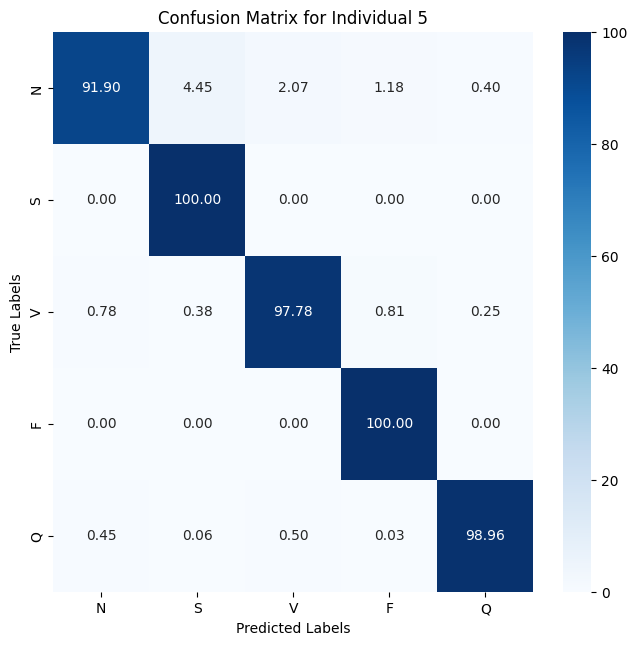

2024-04-16 04:01:58,764 - INFO - Calculating fitness for individual after 3 Phases 6/30


X_params shape: (1, 2)
n_neighbors: 33 p: 5


2024-04-16 04:02:03,313 - INFO - Fitness for individual 6: 0.9703769274751224


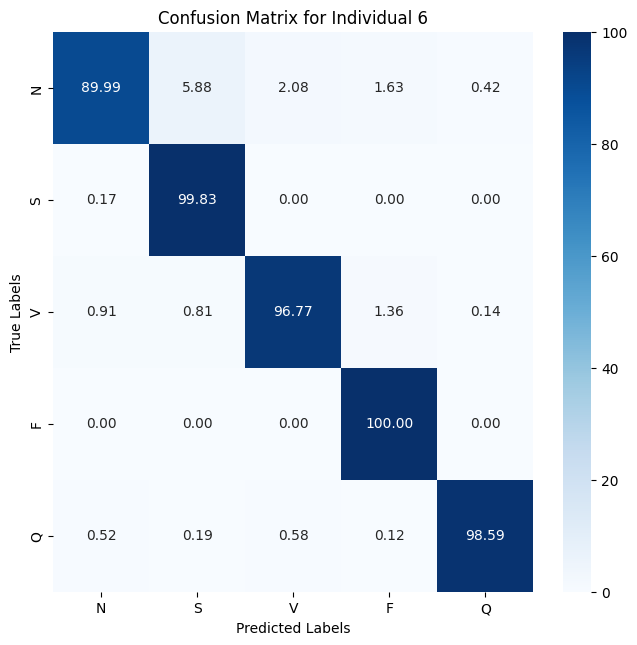

2024-04-16 04:02:03,684 - INFO - Calculating fitness for individual after 3 Phases 7/30


X_params shape: (1, 2)
n_neighbors: 17 p: 14


2024-04-16 04:02:07,920 - INFO - Fitness for individual 7: 0.9826662448332348


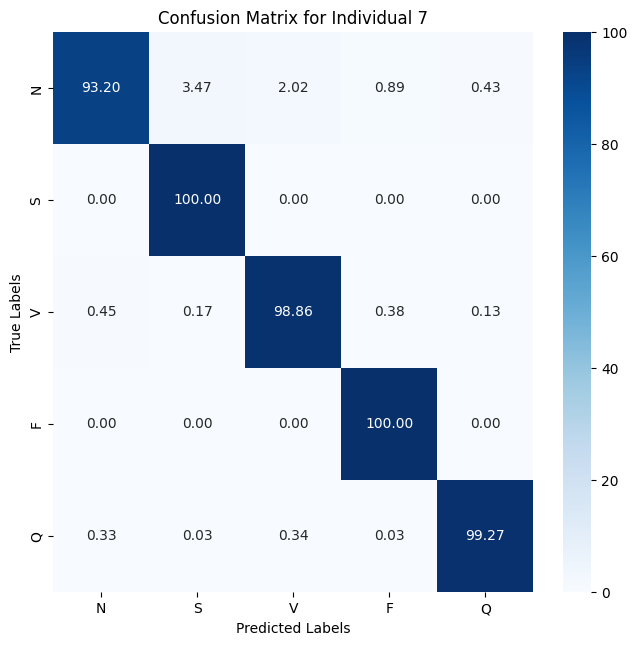

2024-04-16 04:02:08,291 - INFO - Calculating fitness for individual after 3 Phases 8/30


X_params shape: (1, 2)
n_neighbors: 32 p: 12


2024-04-16 04:02:12,547 - INFO - Fitness for individual 8: 0.9714855869479722


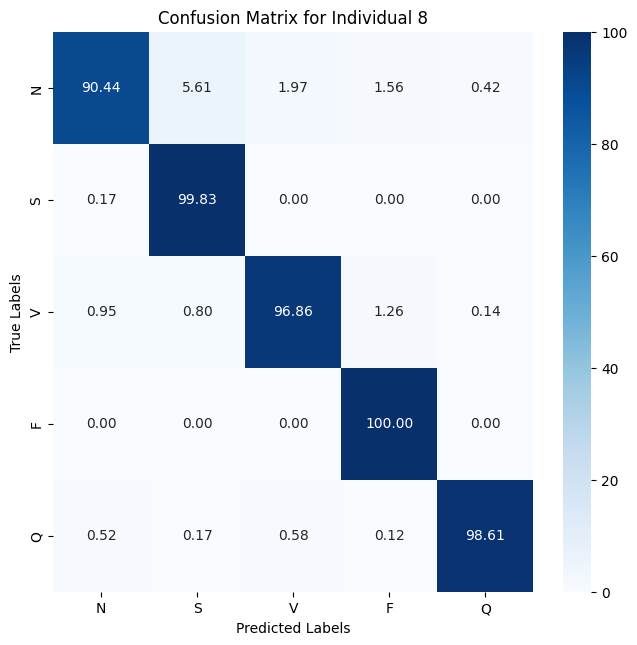

2024-04-16 04:02:12,922 - INFO - Calculating fitness for individual after 3 Phases 9/30


X_params shape: (1, 2)
n_neighbors: 25 p: 1


2024-04-16 04:02:17,160 - INFO - Fitness for individual 9: 0.975628574137988


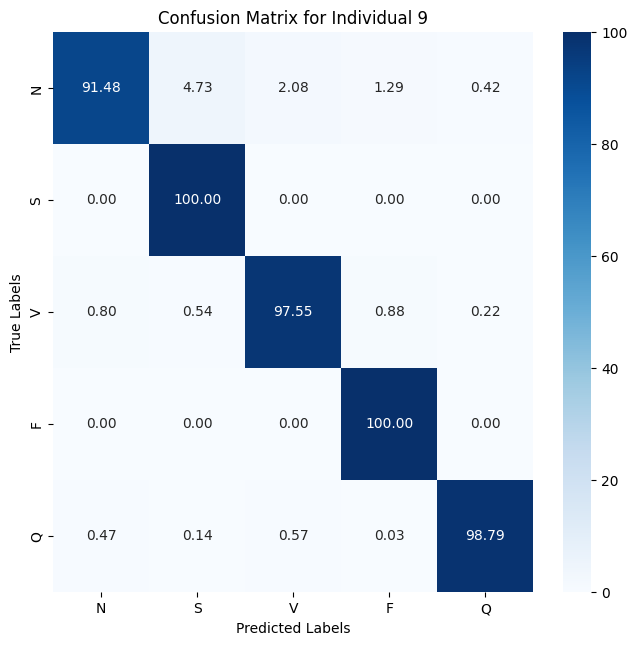

2024-04-16 04:02:17,536 - INFO - Calculating fitness for individual after 3 Phases 10/30


X_params shape: (1, 2)
n_neighbors: 17 p: 1


2024-04-16 04:02:21,818 - INFO - Fitness for individual 10: 0.9826662448332348


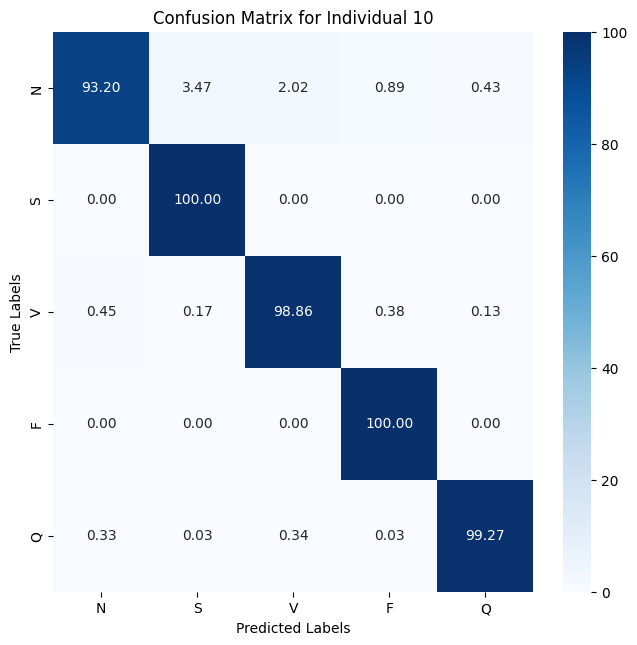

2024-04-16 04:02:22,446 - INFO - Calculating fitness for individual after 3 Phases 11/30


X_params shape: (1, 2)
n_neighbors: 34 p: 32


2024-04-16 04:02:27,013 - INFO - Fitness for individual 11: 0.9701000586845883


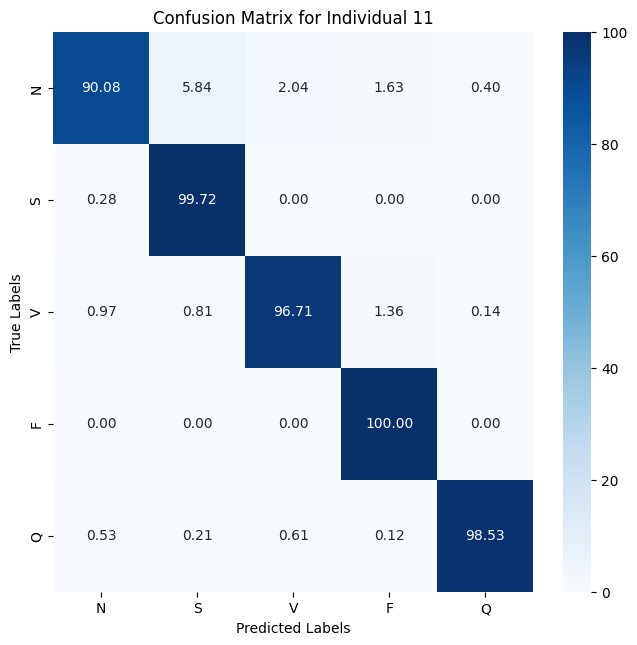

2024-04-16 04:02:27,387 - INFO - Calculating fitness for individual after 3 Phases 12/30


X_params shape: (1, 2)
n_neighbors: 36 p: 23


2024-04-16 04:02:31,950 - INFO - Fitness for individual 12: 0.9689344911350808


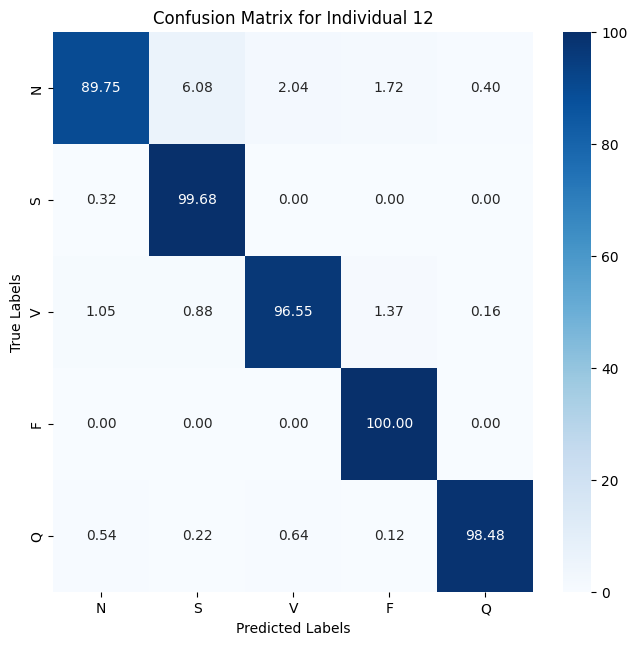

2024-04-16 04:02:32,326 - INFO - Calculating fitness for individual after 3 Phases 13/30


X_params shape: (1, 2)
n_neighbors: 48 p: 38


2024-04-16 04:02:37,164 - INFO - Fitness for individual 13: 0.959323681471429


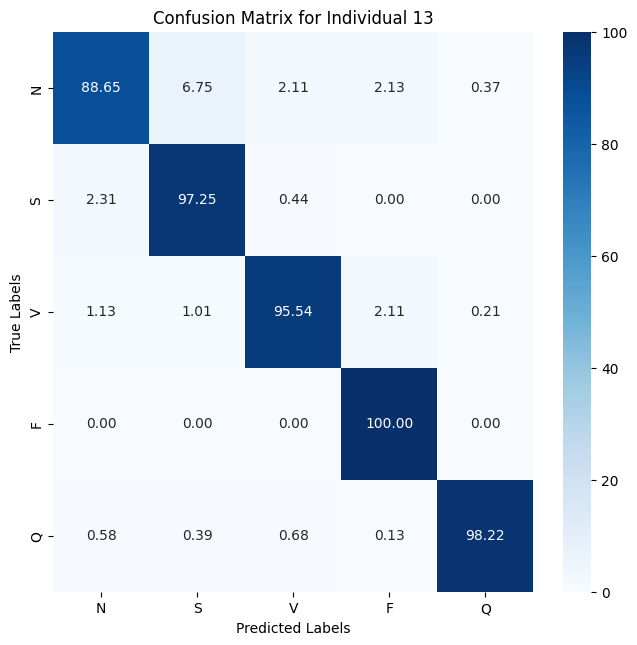

2024-04-16 04:02:37,536 - INFO - Calculating fitness for individual after 3 Phases 14/30


X_params shape: (1, 2)
n_neighbors: 58 p: 8


2024-04-16 04:02:42,123 - INFO - Fitness for individual 14: 0.9533999993760258


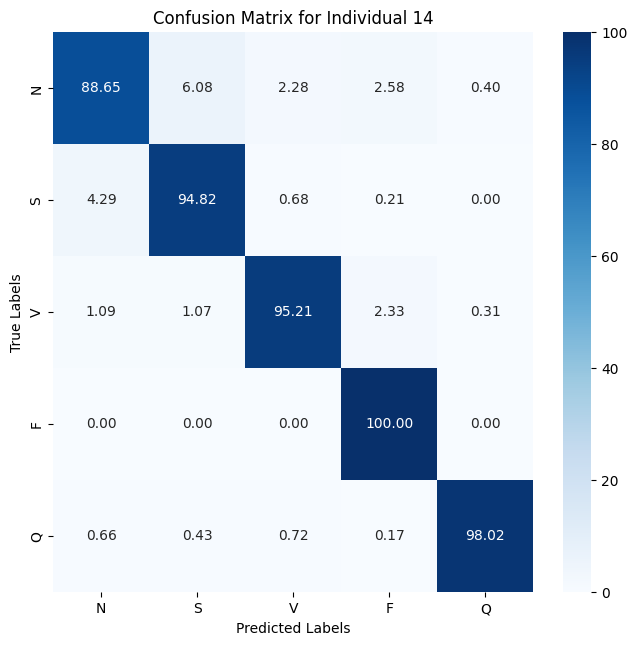

2024-04-16 04:02:42,499 - INFO - Calculating fitness for individual after 3 Phases 15/30


X_params shape: (1, 2)
n_neighbors: 2 p: 14


2024-04-16 04:02:46,533 - INFO - Fitness for individual 15: 0.9979219358807848


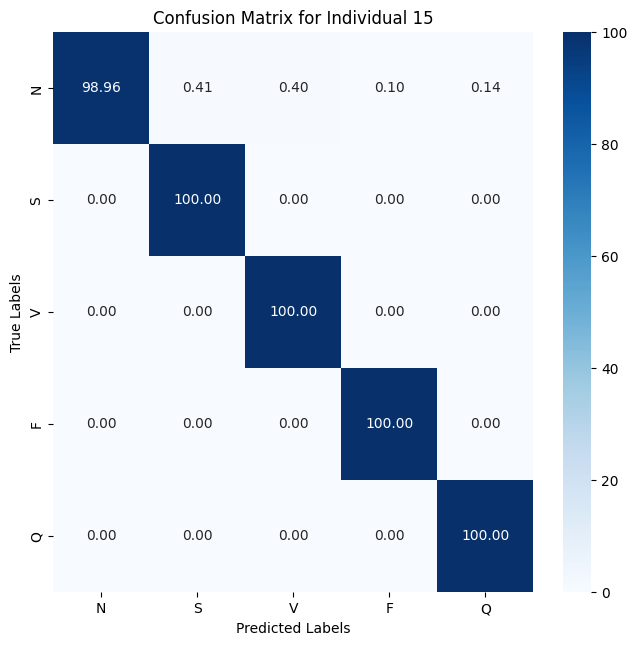

2024-04-16 04:02:46,898 - INFO - Calculating fitness for individual after 3 Phases 16/30


X_params shape: (1, 2)
n_neighbors: 12 p: 11


2024-04-16 04:02:51,085 - INFO - Fitness for individual 16: 0.9888228727208501


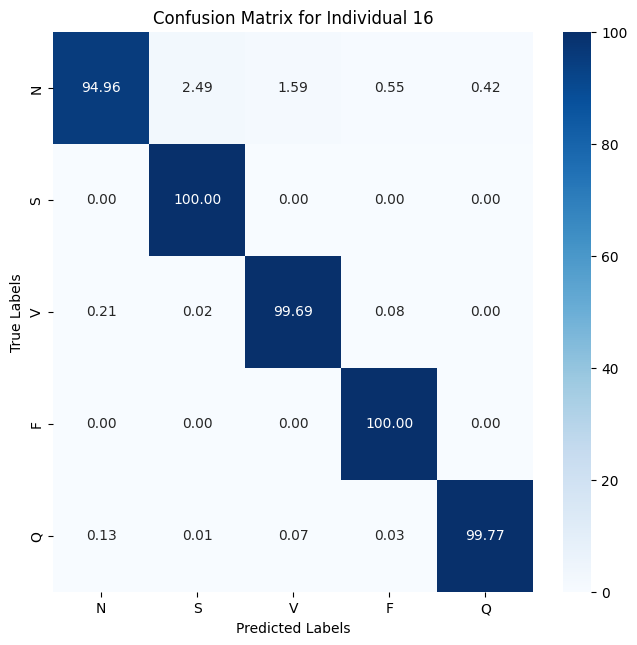

2024-04-16 04:02:51,454 - INFO - Calculating fitness for individual after 3 Phases 17/30


X_params shape: (1, 2)
n_neighbors: 45 p: 34


2024-04-16 04:02:56,028 - INFO - Fitness for individual 17: 0.9619592459980784


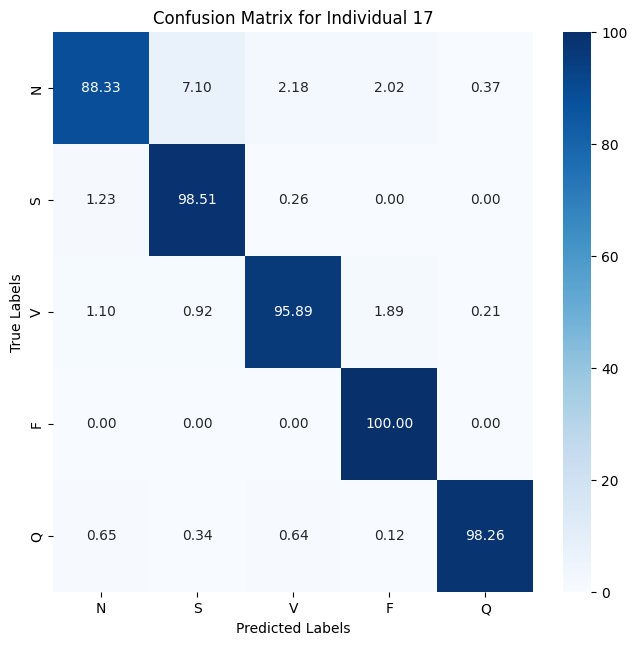

2024-04-16 04:02:56,400 - INFO - Calculating fitness for individual after 3 Phases 18/30


X_params shape: (1, 2)
n_neighbors: 14 p: 14


2024-04-16 04:03:00,615 - INFO - Fitness for individual 18: 0.9869178914251417


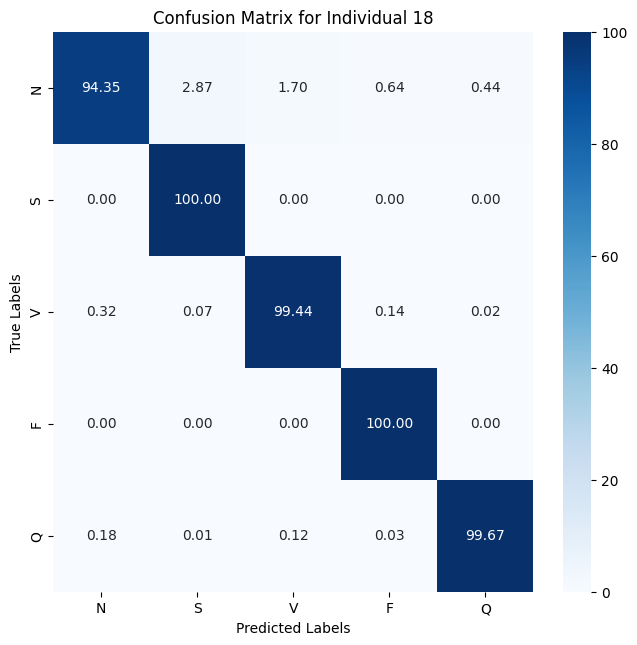

2024-04-16 04:03:00,986 - INFO - Calculating fitness for individual after 3 Phases 19/30


X_params shape: (1, 2)
n_neighbors: 46 p: 17


2024-04-16 04:03:05,569 - INFO - Fitness for individual 19: 0.961445276539127


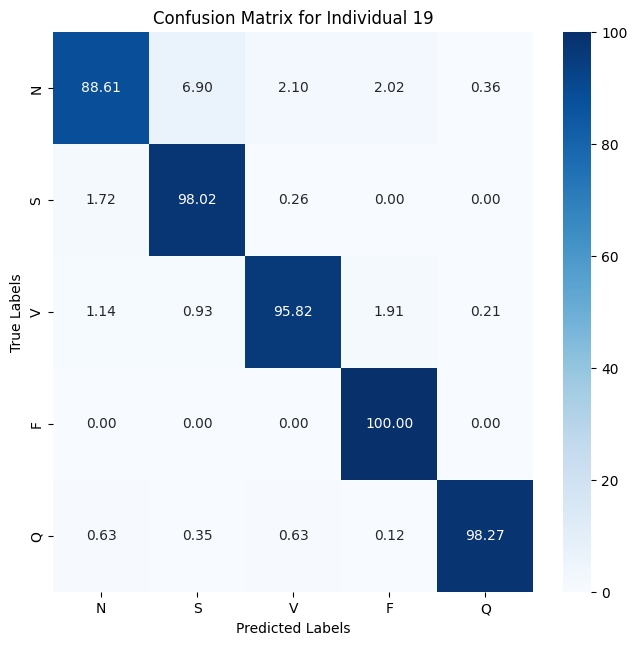

2024-04-16 04:03:05,944 - INFO - Calculating fitness for individual after 3 Phases 20/30


X_params shape: (1, 2)
n_neighbors: 56 p: 1


2024-04-16 04:03:10,573 - INFO - Fitness for individual 20: 0.9549560177649967


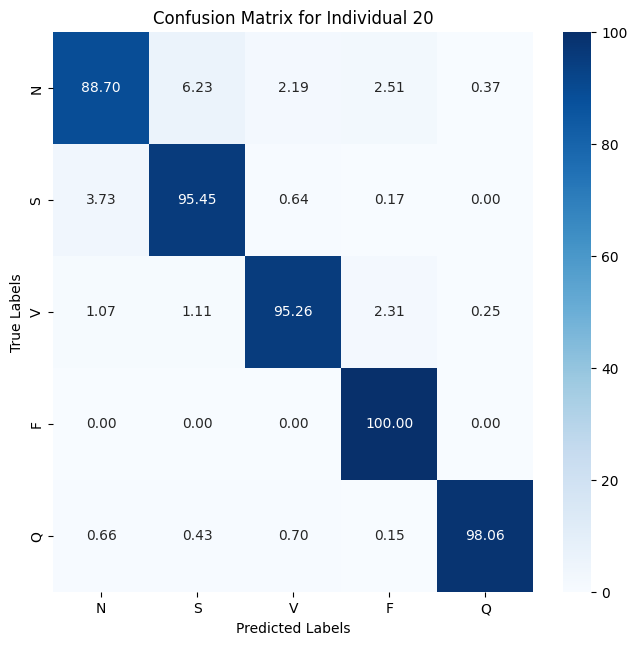

2024-04-16 04:03:10,949 - INFO - Calculating fitness for individual after 3 Phases 21/30


X_params shape: (1, 2)
n_neighbors: 42 p: 11


2024-04-16 04:03:15,541 - INFO - Fitness for individual 21: 0.964703288647506


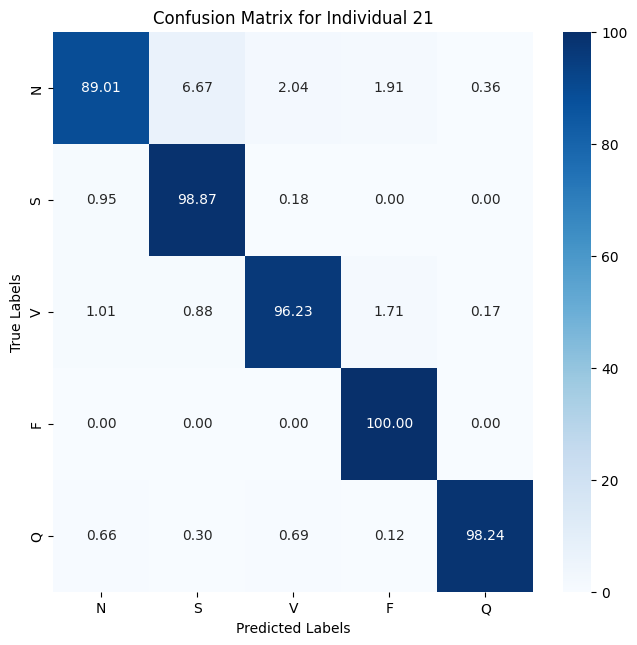

2024-04-16 04:03:15,913 - INFO - Calculating fitness for individual after 3 Phases 22/30


X_params shape: (1, 2)
n_neighbors: 8 p: 11


2024-04-16 04:03:19,920 - INFO - Fitness for individual 22: 0.9926028721243256


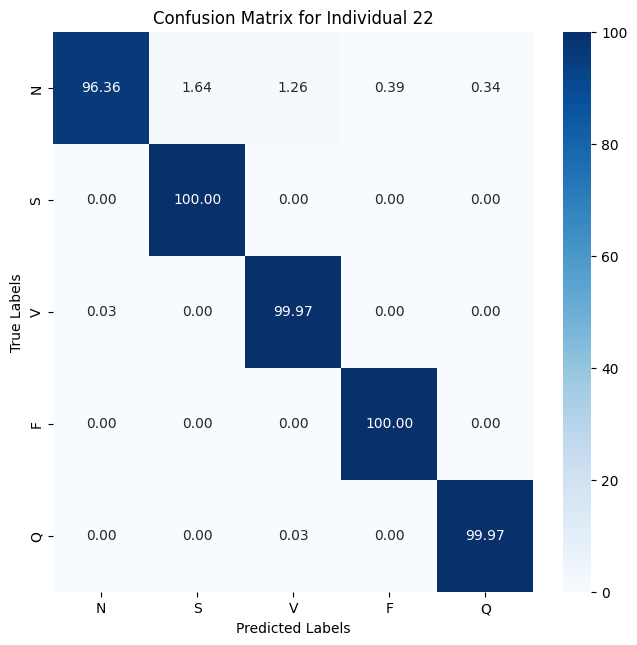

2024-04-16 04:03:20,287 - INFO - Calculating fitness for individual after 3 Phases 23/30


X_params shape: (1, 2)
n_neighbors: 39 p: 17


2024-04-16 04:03:25,145 - INFO - Fitness for individual 23: 0.966399636015187


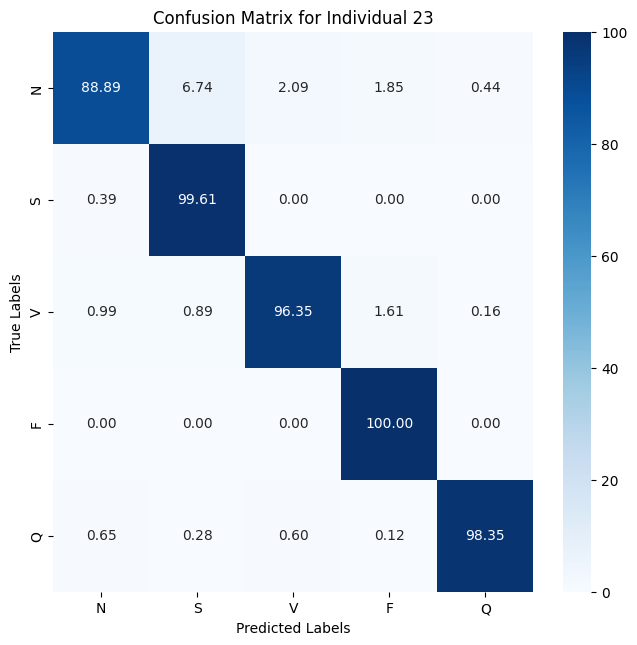

2024-04-16 04:03:25,517 - INFO - Calculating fitness for individual after 3 Phases 24/30


X_params shape: (1, 2)
n_neighbors: 47 p: 10


2024-04-16 04:03:30,105 - INFO - Fitness for individual 24: 0.9601153907736606


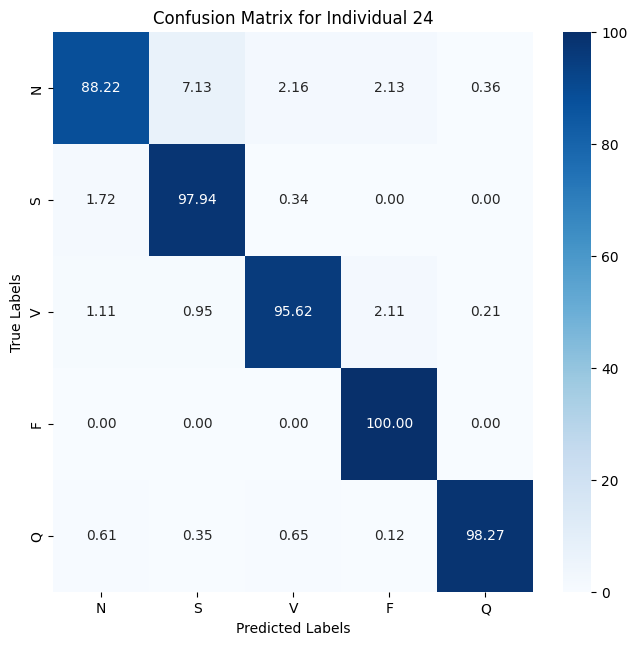

2024-04-16 04:03:30,725 - INFO - Calculating fitness for individual after 3 Phases 25/30


X_params shape: (1, 2)
n_neighbors: 38 p: 8


2024-04-16 04:03:35,295 - INFO - Fitness for individual 25: 0.9674799442103301


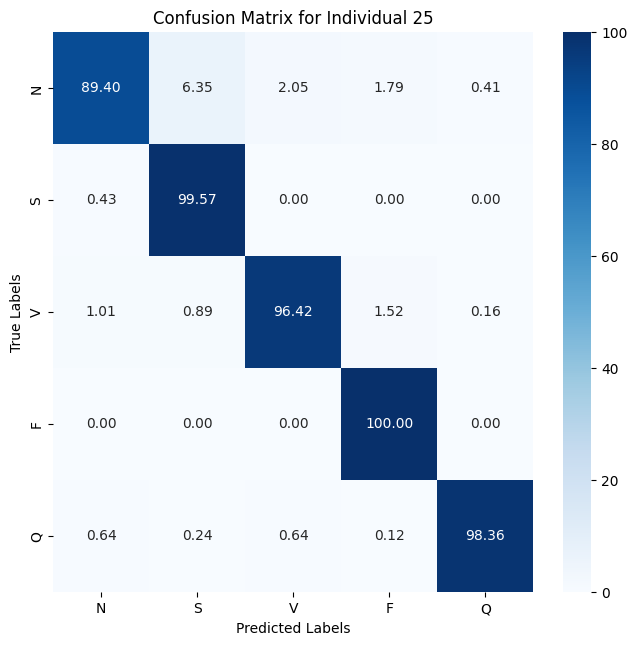

2024-04-16 04:03:35,667 - INFO - Calculating fitness for individual after 3 Phases 26/30


X_params shape: (1, 2)
n_neighbors: 55 p: 27


2024-04-16 04:03:40,259 - INFO - Fitness for individual 26: 0.9551416928458943


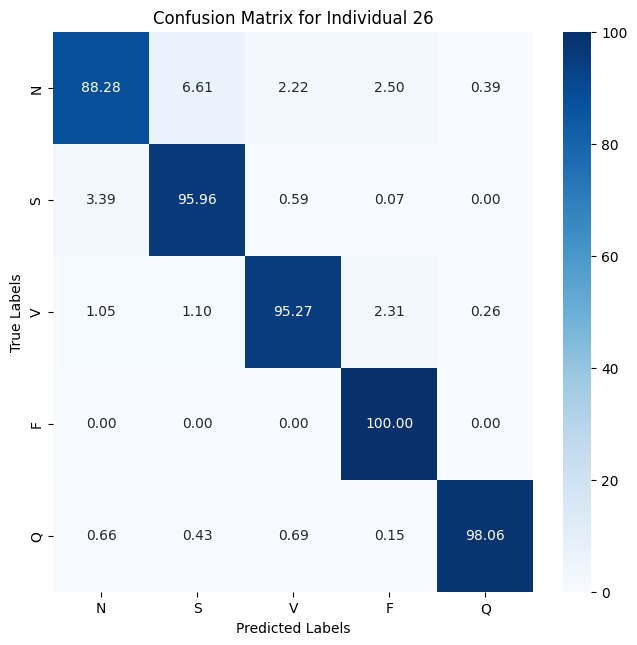

2024-04-16 04:03:40,632 - INFO - Calculating fitness for individual after 3 Phases 27/30


X_params shape: (1, 2)
n_neighbors: 12 p: 22


2024-04-16 04:03:44,850 - INFO - Fitness for individual 27: 0.9888228727208501


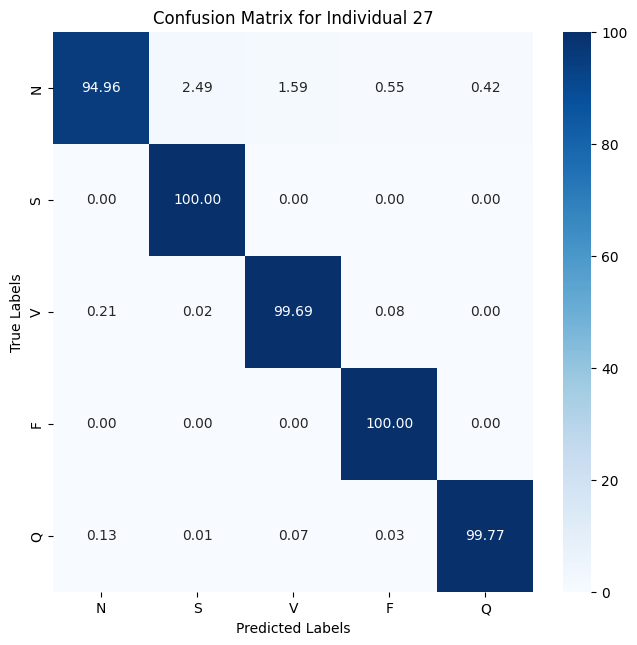

2024-04-16 04:03:45,222 - INFO - Calculating fitness for individual after 3 Phases 28/30


X_params shape: (1, 2)
n_neighbors: 2 p: 12


2024-04-16 04:03:49,189 - INFO - Fitness for individual 28: 0.9979219358807848


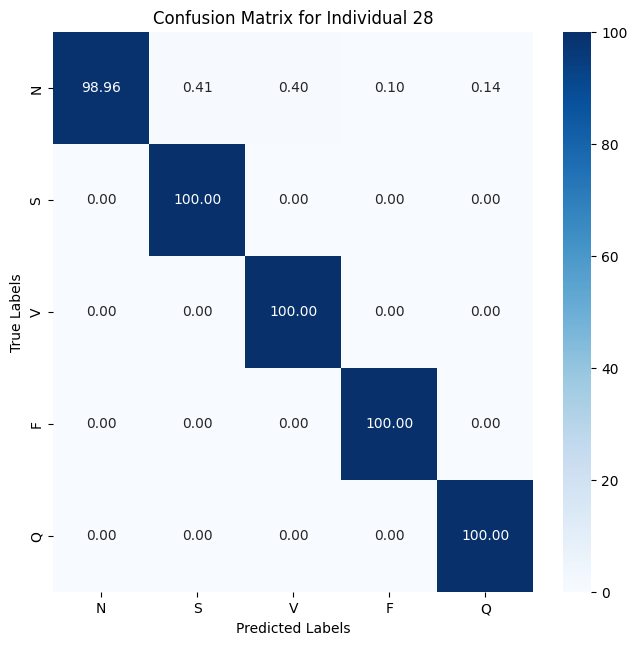

2024-04-16 04:03:49,559 - INFO - Calculating fitness for individual after 3 Phases 29/30


X_params shape: (1, 2)
n_neighbors: 11 p: 35


2024-04-16 04:03:53,755 - INFO - Fitness for individual 29: 0.9890441324278264


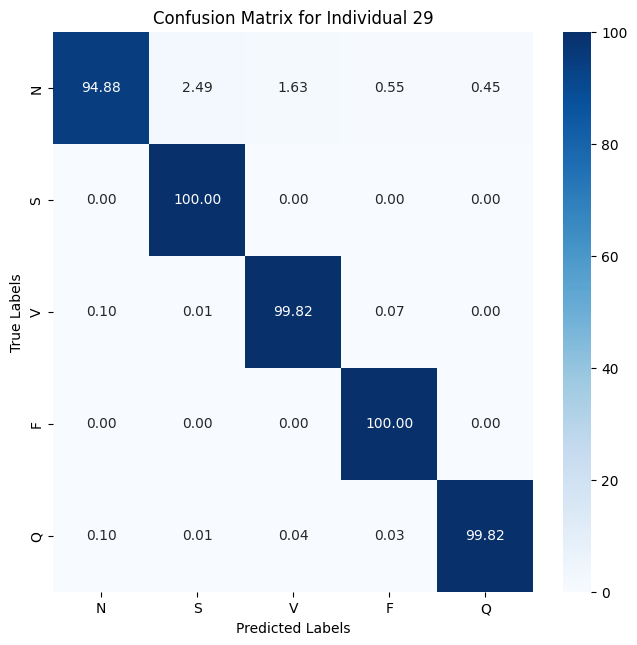

2024-04-16 04:03:54,125 - INFO - Calculating fitness for individual after 3 Phases 30/30


X_params shape: (1, 2)
n_neighbors: 30 p: 16


2024-04-16 04:03:58,353 - INFO - Fitness for individual 30: 0.9727053224806955


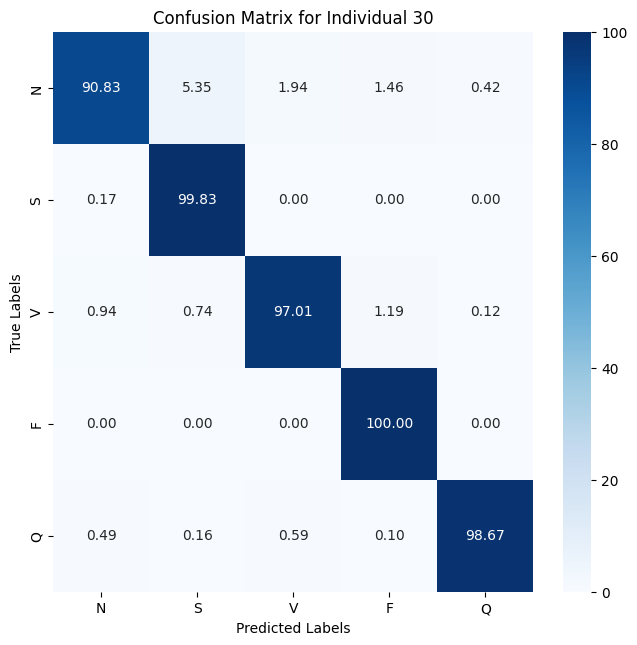

2024-04-16 04:03:58,726 - INFO - Iteration: 1/20, Best Fitness: 0.9979219358807848, Average Fitness: 0.974824590358651
2024-04-16 04:03:58,728 - INFO - Fitness threshold reached: 0.9979219358807848 at iteration 1. Terminating...
2024-04-16 04:03:58,729 - INFO - Model saved to best_model_mpa_kNN_mit.pkl with fitness 0.9979219358807848 at iteration 1
2024-04-16 04:03:58,730 - INFO - Finished MPA_kNN optimization for MIT dataset. Total duration: 4.82 minutes.
2024-04-16 04:03:58,732 - INFO - Top predator position (rounded to integers): [2, 14]
2024-04-16 04:03:58,733 - INFO - Top predator fitness: 0.9979219358807848


Top predator position (rounded to integers): [2, 14]
Top predator fitness: 0.9979219358807848


In [7]:
import time

def run_mpa_for_all_labels(X_train, X_val, y_train, y_val, search_agents_no, Max_iter, lb, ub, dim, kNN_accuracy_fitness, fitness_threshold=0.95):
    """
    Runs MPA optimization for all labels and plots the convergence curve for each label.

    Parameters:
    - X_train, X_val, y_train, y_val: Training and validation sets.
    - search_agents_no: Number of search agents.
    - Max_iter: Maximum number of iterations.
    - lb, ub: Lower and upper bounds for optimization parameters.
    - dim: Number of dimensions/hyperparameters.
    - rf_accuracy_fitness: Fitness function for the Random Forest model.
    - fitness_threshold: Threshold for stopping the optimization.
    """
    overall_start_time = time.time()

    # Example usage with correctly structured return values for MPA
    results = {}  # Assuming MPA should populate this dictionary
    
    # Example call to MPA for one label (extend as needed for multiple labels)
    top_predator_pos, top_predator_fit = MPA(
        search_agents_no, Max_iter, lb, ub, dim, 
        X_train, y_train, X_val, y_val, 
        kNN_accuracy_fitness, fitness_threshold
    )
    
    # Rounding top predator position to nearest integers for logging and usage
    rounded_top_predator_pos = [round(pos) for pos in top_predator_pos]

    # Populate the results dictionary with mock label data (extend as needed)
    results['MockLabel'] = {
        'Top_predator_pos': rounded_top_predator_pos,
        'Top_predator_fitness': top_predator_fit
    }

    overall_end_time = time.time()
    total_duration_minutes = (overall_end_time - overall_start_time) / 60

    # Get the top predator position and fitness from the 'results' dictionary for the mock label
    top_predator_pos = results['MockLabel']['Top_predator_pos']
    top_predator_fit = results['MockLabel']['Top_predator_fitness']
    
    # Log the top predator fitness and position
    logging.info(f"Finished MPA_kNN optimization for MIT dataset. Total duration: {total_duration_minutes:.2f} minutes.")
    logging.info(f"Top predator position (rounded to integers): {top_predator_pos}")
    logging.info(f"Top predator fitness: {top_predator_fit}")
    
    # Optionally, print them out to the console as well
    print(f"Top predator position (rounded to integers): {top_predator_pos}")
    print(f"Top predator fitness: {top_predator_fit}")


run_mpa_for_all_labels(X_train, X_val, y_train, y_val, search_agents_no, Max_iter, lb, ub, dim, kNN_accuracy_fitness, fitness_threshold=0.95)


### Evaluate on Test dataset

In [8]:
import cudf
# Example loading test data (adjust path and processing as needed)
test_data = cudf.read_csv('/home/jupyter-yangiev/MPA_int_ML/mitbih_test_new.csv')

columns = test_data.columns.tolist()
features = [col for col in columns if col != '187']
labels = '187'

X_test = test_data[features].astype('float32')
y_test = test_data['187'].astype('int32')  # Adjust label column as per your dataset


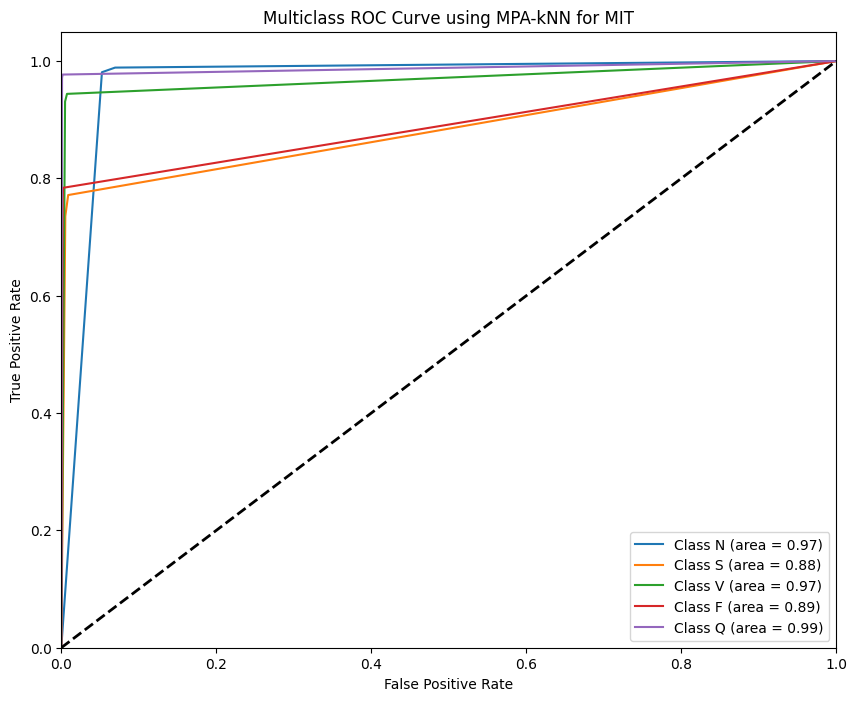

              precision    recall  f1-score   support

           N       0.76      0.77      0.76       162
           S       0.99      0.99      0.99     18118
           V       0.99      0.97      0.98      1608
           F       0.79      0.74      0.76       556
           Q       0.93      0.93      0.93      1448

    accuracy                           0.98     21892
   macro avg       0.89      0.88      0.88     21892
weighted avg       0.98      0.98      0.98     21892

roc_auc_ovr score: 0.9397731109037217
roc_auc_ovo score: 0.9397731109037217


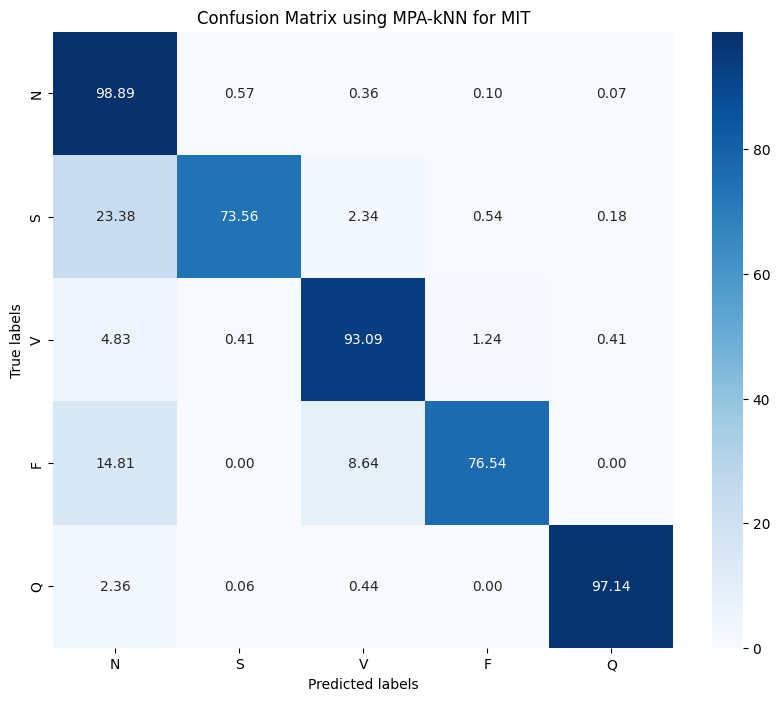

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cuml.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score
import seaborn as sns
from cuml import set_global_output_type
import numpy as np

# Set global output type to cupy for cuML compatibility with cuPy
set_global_output_type('cupy')

# Load the best model saved from MPA
with open('best_model_mpa_kNN_mit.pkl', 'rb') as f:
    model = pickle.load(f)
    
model.fit(X_train, y_train)

# Predict probabilities for ROC AUC  
y_prob = model.predict_proba(X_test).get()

# Predict class labels for confusion matrix and other metrics  
y_pred = model.predict(X_test).get()

# Convert y_test to NumPy
y_test_np = y_test.to_numpy()

# Custom label mapping
label_mapping = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

# Apply the mapping to your test labels and predictions
y_test_mapped = np.vectorize(label_mapping.get)(y_test_np)
y_pred_mapped = np.vectorize(label_mapping.get)(y_pred)

# Binarize the output for multiclass ROC AUC
y_test_bin = label_binarize(y_test_mapped, classes=list(label_mapping.values()))
n_classes = y_test_bin.shape[1]

# Calculate performance metrics
roc_auc_ovr = roc_auc_score(y_test_bin, y_prob, multi_class='ovr', average='macro')
roc_auc_ovo = roc_auc_score(y_test_bin, y_prob, multi_class='ovo', average='macro')
precision = precision_score(y_test_mapped, y_pred_mapped, average='macro')
recall = recall_score(y_test_mapped, y_pred_mapped, average='macro')
f1 = f1_score(y_test_mapped, y_pred_mapped, average='macro')
accuracy = accuracy_score(y_test_mapped, y_pred_mapped)

# Compute ROC curve and ROC area for each class
fpr, tpr, roc_auc = {}, {}, {}
for i, label in enumerate(label_mapping.values()):
    fpr[label], tpr[label], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[label] = auc(fpr[label], tpr[label])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for label in label_mapping.values():
    plt.plot(fpr[label], tpr[label], label=f'Class {label} (area = {roc_auc[label]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve using MPA-kNN for MIT')
plt.legend(loc="lower right")
# Save the figure
plt.savefig('roc_curve_mpa_kNN_mit.png', format='png', dpi=300)  # Save as high-res PNG
plt.show()


# Display classification report
print(classification_report(y_test_mapped, y_pred_mapped, target_names=list(label_mapping.values())))
print(f"roc_auc_ovr score: {roc_auc_ovr}")
print(f"roc_auc_ovo score: {roc_auc_ovo}")

# Assuming y_test_mapped and y_pred_mapped are already defined
cm = confusion_matrix(y_test_mapped, y_pred_mapped, labels=list(label_mapping.values()))

# Calculate the percentage for each cell in the confusion matrix
cm_percent = 100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Custom labels for the axes
labels = ['N', 'S', 'V', 'F', 'Q']

# Plotting using seaborn for more customization like annotations
plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", cbar=True, 
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix using MPA-kNN for MIT')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig('confusion_matrix_mpa_kNN_mit.png', format='png', dpi=300)  # Save as high-res PNG
plt.show()
